# Tugas Tren Visi Komputer - Football Player Detection

### Muhammad Rafly Arjasubrata - 20301240028

### Muhammad Abiya Makruf - 203012420034

**Notebook ini digunakan untuk pelatihan model pada kaggle**

*Session Configuration*
- Accelerator : 2x - Nvidia Tesla T4 GPU 16GB
- Language : Python
- Presistence : Files
- Environment : Original Docker Environment from Kaggle

# Download Module yang Digunakan

In [2]:
!pip install ultralytics -q
!pip install roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 24.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.3 MB/s eta 0:00:00:00:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [1]:
# !rm -rf /kaggle/working/runs

# Download dataset from Roboflow

## **Roboflow**, dari data hingga model
Roboflow adalah platform end-to-end yang dirancang untuk mempermudah proses pengembangan model computer vision, mulai dari pengelolaan dataset hingga pelatihan dan deployment model. Pengguna dapat mengunggah, mengelola, dan melakukan augmentasi dataset dengan cepat. Roboflow mendukung berbagai format anotasi dan kompatibel dengan framework populer seperti YOLO, TensorFlow, dan PyTorch. Selain itu, Roboflow menyediakan layanan pelatihan model secara otomatis di cloud, serta API untuk mengintegrasikan model yang sudah jadi ke dalam aplikasi nyata, menjadikannya solusi lengkap untuk alur kerja computer vision.

**Top 3 fitur terpenting Roboflow (menurut kami)**
1. **Dataset Annotation & Management** <br>
Fitur ini memungkinkan pengguna untuk melakukan anotasi, mengelola (versioning dan splitting), dan mengonversi anotasi dataset ke berbagai format secara otomatis.

2. **Augmentasi yang Otomatis**
Menyediakan berbagai teknik augmentasi untuk meningkatkan variasi data dan performa model.

3. **Model Training & Deployment**
Walaupun terbatas, Roboflow memfasilitasi pelatihan model secara langsung di cloud dan menyederhanakan proses deployment dengan API yang siap pakai.


## Dataset yang digunakan

Dataset ***Football Players Detection*** merupakan kumpulan data yang sudah dianotasi di Roboflow untuk mendeteksi pemain sepak bola pada suatu pertandingan. Dengan dataset ini, model deteksi dapat dilatih untuk mendeteksi keberadaan pemain secara otomatis, yang dapat diterapkan dalam analisis pertandingan datau pelacakan permain.

Terdapat 4 kelas yang terdapat pada dataset tersebut, yaitu
1. Player
2. Goalkeeper
3. Referee
4. Ball

Namun pada hasil yang dicoba melalui API Roboflow, untuk class "Ball" sangat sulit terdeteksi karena ukuran bola yang kecil.

Maka pada penelitian ini, akan dicoba berbagai kombinasi ukuran input dan ukuran model yang berbeda untuk melihat perbedaan performa antar model yang diuji.

Tujuan penelitian ini adalah untuk mengetahui manakah yang lebih berpengaruh, meningkatkan ukuran input atau meningkatkan ukuran arsitektur.

### Download dataset menggunakan API Roboflow

Dataset ***Football Players Detection*** diunduh menggunakan API langsung dari roboflow. Hal ini dilakukan agar proses download cepat dan tidak harus membuka website dari roboflow sendiri.

Manfaat lain dari API ini adalah dapat menggabungkan ke pipeline CI/CD agar memudahkan otomatisasi alur pelatihan model.

In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="9sOZx0yv9I41c8VbWtgN")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(12)
dataset = version.download("yolov12")

loading Roboflow workspace...
loading Roboflow project...


In [4]:
# Yaml path for dataset
data_path = "/kaggle/working/football-players-detection-12/data.yaml"

In [3]:
from ultralytics import YOLO
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import torch
import gc

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Ultralytics - You Only Train Once

Ultralytics merupakan perusahaan teknologi yang dikenal luas sebagai pengembang dari beberapa seri YOLO, yaitu YOLOv5, YOLOv8, YOLOv9 hingga YOLOv12, yang merupakan suatu *framework* deteksi objek yang sangat populer dan efisien.

Ultralytics YOLO merupakan implementasi dari arsitektur YOLO yang ditulis dalam Python dan PyTorch, yang menawarkan kemudahan penggunaan untuk pelatihan, validasi, inferensi, dan deployment dari model.

Keunggulan utama **Ultralytics** sendiri terdapat pada dokumentasi yang lengkap, kode yang mudah digunakan, dan fitur seperti *auto learning-rate*, *augmentasi otomatis*, dan dukungan ke berbagai format export seperti ke TensorFlow Saved Model, Pytorch Model, dan lainnya.

Ultralytics tersedia secara *open-source*, namun lisensi yang digunakan adalah **AGPL 3.0**, yang mengharuskan publikasi kode jika dimodifikasi atau digunakan untuk komersial. Hal tersebut yang membuat harus berhati-hati dalam penggunaan Ultralytics YOLO.

## YOLOv12 - Attention Centric Model

YOLOv12 adalah iterasi terbaru dalam Ultralytics YOLO yang memperkenalkan arsitektur yang berpusat pada *Attention Mechanism* untuk meningkatkan akurasi deteksi sambil mempertahankan kecepatan inferensi. Peningkatan ini memungkinkan YOLOv12 mencapai keseimbangan optimal antara akurasi dan efisiensi, menjadikannya pilihan untuk analitik *real-time*

In [6]:
class YOLOv12Model :
    def __init__(self, model_size, input_size, epochs):
        size_map = {
            'n': 'nano',
            's': 'small',
            'm': 'medium',
            'l': 'large',
            'x': 'xlarge'
        }
        
        # hyper-parameter proses training
        self.model_size = model_size
        self.input_size = input_size
        self.epochs = epochs
        self.batch = 12

        # Konfigurasi training
        self.device = [0]
        self.name = f"{size_map[model_size]}-{input_size}"
        self.model = None
        self.metrics = None

    def train(self, data_path):
        '''
        Train model pada hyperparameter yang ditentukan
        '''
        # Load pretrained model (Weight COCO)
        self.model = YOLO(f'yolo12{self.model_size}.pt')

        # Train model
        self.model.train(
            data=data_path,
            epochs=self.epochs,
            imgsz=self.input_size,
            batch=self.batch,
            device=self.device,
            name=self.name
        )

        # Clear GPU memory
        self._clear_gpu_memory()

    def validate(self):
        '''
        Validasi model pada data uji
        '''
        self.metrics = self.model.val()

        # Clear GPU memory
        self._clear_gpu_memory()
        # Hapus folder residual
        shutil.rmtree(f"/kaggle/working/runs/detect/{self.name}2")

    def save_metrics(self):
        '''
        Simpan metrik evaluasi dari data uji ke txt
        '''
        if self.metrics == None :
            print("Metrics not available")

        # Load metrics
        class_names = self.metrics.names
        precision = self.metrics.box.p
        recall = self.metrics.box.r
        mAP50 = self.metrics.box.ap50
        mAP50_95 = self.metrics.box.ap

        # File path untuk menuliskan metrik
        file_path = f"/kaggle/working/runs/detect/{self.name}/test_results.txt"

        # Tulis metrik ke txt
        with open(file_path, 'w') as f:
            f.write("Class Name\tPrecision\tRecall\tmAP50\tmAP50-95\n")
            for class_idx, class_name in class_names.items():
                f.write(f"{class_name}\t"
                        f"{precision[class_idx]:.4f}\t"
                        f"{recall[class_idx]:.4f}\t"
                        f"{mAP50[class_idx]:.4f}\t"
                        f"{mAP50_95[class_idx]:.4f}\n")

        print(f"Metrics saved to {file_path}")

    def _clear_gpu_memory(self):
        '''
        Clear memory di GPU
        '''
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        gc.collect()

    def _delete_model(self):
        '''
        Delete model di System Memory
        '''
        del self.model
        gc.collect()

# Pelatihan Model

3 Ukuran model dilatih dan dievaluasi dengan 3 ukuran input berbeda seperti tabel dibawah

| |480x480|640x640|720x720|
|-|-------|-------|-------|
|nano|1.61G|3.54G|5.16G|
|small|2.90G|5.35G|8.03G|
|medium |5.24G|10.21G|13.10G| 

Peningkatan ukuran model (GFLOPs) meningkat seiring dengan meningkatnya ukuran input dan ukuran arsitektur. Maka pada penelitian ini akan menjawab mana yang lebih berpengaruh antara ukuran input dan ukuran model pada performa model ,terutama performa pada deteksi bola dengan menimbang ukuran model.

# YOLOv12n - Nano

In [7]:
# Buat objek model untuk setiap ukuran input berbeda
nano_models = {
    '480' : YOLOv12Model('n', 480, 50),
    '640' : YOLOv12Model('n', 640, 50),
    '720' : YOLOv12Model('n', 720, 50)
}

## Train nano model - 480 x 480

In [ ]:
nano_models['480'].train(data_path)
nano_models['480'].validate()
nano_models['480'].save_metrics()
nano_models['480']._delete_model() # Hapus untuk hemat memori

Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=/kaggle/working/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=480, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=nano-480, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /kaggle/working/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to runs/detect/nano-480/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 4 dataloader workers
Logging results to runs/detect/nano-480
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.61G      1.962       3.69     0.9382        245        480: 100%|██████████| 25/25 [00:05<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]

                   all         49       1174          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.62G      1.936       2.05     0.8835        307        480: 100%|██████████| 25/25 [00:03<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.91it/s]

                   all         49       1174   0.000486    0.00231   0.000362   9.33e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.62G      1.851      1.505     0.8623        267        480: 100%|██████████| 25/25 [00:03<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.65it/s]

                   all         49       1174     0.0273      0.155     0.0587     0.0214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.62G      1.826      1.388     0.8681        308        480: 100%|██████████| 25/25 [00:03<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]


                   all         49       1174      0.935      0.138      0.174     0.0756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.69G      1.715      1.261     0.8587        267        480: 100%|██████████| 25/25 [00:03<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]

                   all         49       1174      0.674      0.185      0.201      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.69G      1.687      1.199     0.8591        407        480: 100%|██████████| 25/25 [00:03<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.06it/s]

                   all         49       1174      0.682      0.213      0.204     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.69G      1.692      1.193     0.8575        271        480: 100%|██████████| 25/25 [00:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]

                   all         49       1174      0.425       0.24      0.217      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.77G      1.655       1.13     0.8529        366        480: 100%|██████████| 25/25 [00:03<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.63it/s]

                   all         49       1174      0.455      0.261       0.24       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.77G      1.663      1.107     0.8549        272        480: 100%|██████████| 25/25 [00:03<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]

                   all         49       1174      0.769      0.238      0.253      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.77G      1.608      1.076      0.854        295        480: 100%|██████████| 25/25 [00:03<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.74it/s]

                   all         49       1174      0.811      0.244      0.271      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.77G      1.521      1.025     0.8453        339        480: 100%|██████████| 25/25 [00:03<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]

                   all         49       1174       0.82       0.25       0.28      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.77G      1.593      1.029     0.8448        388        480: 100%|██████████| 25/25 [00:03<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]

                   all         49       1174      0.715      0.282      0.299      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.77G      1.596      1.039     0.8496        454        480: 100%|██████████| 25/25 [00:03<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]

                   all         49       1174      0.686      0.291      0.329      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.77G      1.577      1.024      0.833        336        480: 100%|██████████| 25/25 [00:03<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

                   all         49       1174      0.673      0.308      0.362      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.77G      1.508     0.9799     0.8432        324        480: 100%|██████████| 25/25 [00:03<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

                   all         49       1174      0.716      0.374      0.413      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.77G      1.457     0.9166     0.8336        425        480: 100%|██████████| 25/25 [00:03<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.22it/s]

                   all         49       1174      0.416       0.41      0.451      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.77G      1.418     0.8815     0.8369        294        480: 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.19it/s]

                   all         49       1174      0.741      0.447       0.47      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.77G      1.421     0.8387     0.8241        341        480: 100%|██████████| 25/25 [00:03<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.83it/s]

                   all         49       1174      0.849      0.436      0.526        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.77G      1.365     0.8066     0.8276        280        480: 100%|██████████| 25/25 [00:03<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.42it/s]

                   all         49       1174      0.822      0.462      0.534      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.77G      1.366     0.7951     0.8212        296        480: 100%|██████████| 25/25 [00:03<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.47it/s]

                   all         49       1174       0.85      0.464       0.55      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.77G      1.361     0.7903     0.8246        152        480: 100%|██████████| 25/25 [00:03<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.17it/s]


                   all         49       1174      0.802      0.491       0.54      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.77G      1.355     0.7888      0.822        308        480: 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.39it/s]


                   all         49       1174      0.876      0.457      0.545      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.77G      1.423     0.8015     0.8213        343        480: 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.25it/s]


                   all         49       1174      0.834      0.465      0.531       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.77G      1.373     0.7816     0.8264        194        480: 100%|██████████| 25/25 [00:04<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]


                   all         49       1174      0.771      0.515      0.532      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.77G      1.388     0.7847     0.8212        313        480: 100%|██████████| 25/25 [00:03<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


                   all         49       1174      0.752      0.499      0.529      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.77G      1.369     0.7718     0.8183        260        480: 100%|██████████| 25/25 [00:03<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.11it/s]


                   all         49       1174      0.794      0.465      0.533      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.77G      1.342     0.7631     0.8208        336        480: 100%|██████████| 25/25 [00:03<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.72it/s]

                   all         49       1174      0.897      0.451      0.561       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.77G      1.293     0.7235     0.8201        352        480: 100%|██████████| 25/25 [00:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.87it/s]

                   all         49       1174      0.851      0.494      0.569       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.77G      1.352     0.7412     0.8181        427        480: 100%|██████████| 25/25 [00:03<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.39it/s]


                   all         49       1174       0.83       0.49       0.56      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.77G      1.328     0.7423      0.821        202        480: 100%|██████████| 25/25 [00:03<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.36it/s]

                   all         49       1174      0.851      0.506      0.575      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.77G      1.306     0.7297     0.8192        409        480: 100%|██████████| 25/25 [00:04<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.23it/s]


                   all         49       1174      0.904       0.46      0.579      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.77G      1.267     0.7045     0.8148        254        480: 100%|██████████| 25/25 [00:03<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]


                   all         49       1174      0.822      0.515      0.583      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.77G      1.247     0.6974      0.819        390        480: 100%|██████████| 25/25 [00:03<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.12it/s]


                   all         49       1174      0.875      0.506      0.589       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.77G      1.271      0.706     0.8139        353        480: 100%|██████████| 25/25 [00:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.79it/s]

                   all         49       1174      0.878      0.515      0.585      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.77G      1.239     0.6921     0.8169        206        480: 100%|██████████| 25/25 [00:03<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

                   all         49       1174       0.85      0.516      0.589      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.77G      1.274     0.7057     0.8176        255        480: 100%|██████████| 25/25 [00:03<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]


                   all         49       1174      0.856      0.516      0.585      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.77G      1.245     0.6804     0.8159        380        480: 100%|██████████| 25/25 [00:03<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.03it/s]


                   all         49       1174      0.865       0.52      0.586      0.344
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.77G      1.194     0.6799     0.8242        235        480: 100%|██████████| 25/25 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.20it/s]


                   all         49       1174      0.884      0.519       0.59      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.77G      1.143     0.6565     0.8151        221        480: 100%|██████████| 25/25 [00:03<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.24it/s]


                   all         49       1174      0.831      0.526      0.582      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.77G      1.114     0.6351     0.8144        228        480: 100%|██████████| 25/25 [00:03<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.83it/s]

                   all         49       1174       0.85      0.539        0.6      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.77G      1.146     0.6484     0.8165        226        480: 100%|██████████| 25/25 [00:03<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.57it/s]

                   all         49       1174      0.851      0.539      0.592      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.77G       1.12     0.6323     0.8142        225        480: 100%|██████████| 25/25 [00:03<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.80it/s]

                   all         49       1174       0.88      0.494      0.588      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.77G      1.083     0.6194      0.812        272        480:  84%|████████▍ | 21/25 [00:03<00:00,  6.96it/s]

## Train nano model - 640 x 640

In [9]:
nano_models['640'].train(data_path)
nano_models['640'].validate()
nano_models['640'].save_metrics()
nano_models['640']._delete_model() # Hapus untuk hemat memori


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.54G       1.32       1.01     0.8573        280        640: 100%|██████████| 25/25 [00:05<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         49       1174      0.849      0.269      0.292      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.68G      1.356      1.018     0.8577        301        640: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all         49       1174       0.86      0.271      0.298      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.68G      1.264     0.9617     0.8542        342        640: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         49       1174      0.522      0.321      0.331      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.68G      1.331     0.9535      0.849        391        640: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         49       1174       0.61       0.38      0.386      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.68G      1.231     0.9114     0.8482        466        640: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all         49       1174       0.68      0.448       0.45      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.68G      1.255     0.8657       0.84        344        640: 100%|██████████| 25/25 [00:05<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

                   all         49       1174       0.79      0.511      0.534      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.68G       1.24     0.8431     0.8457        331        640: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         49       1174      0.782      0.553      0.589      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.68G      1.255     0.8299     0.8422        439        640: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all         49       1174      0.793      0.554      0.573       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.68G      1.192     0.7867     0.8412        297        640: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         49       1174      0.813      0.567      0.629      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.68G      1.188     0.7737     0.8398        290        640: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         49       1174      0.813      0.579      0.639      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.68G      1.218     0.7676     0.8385        420        640: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.26it/s]

                   all         49       1174      0.828      0.576      0.604      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.68G      1.245     0.7867     0.8417        333        640: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]

                   all         49       1174      0.772      0.512      0.559      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.68G      1.179     0.7563     0.8368        348        640: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]

                   all         49       1174      0.849       0.58      0.613      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.68G      1.201     0.7708     0.8406        291        640: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.49it/s]

                   all         49       1174      0.882      0.525      0.632      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.68G      1.205     0.7518     0.8346        318        640: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

                   all         49       1174      0.783      0.593      0.637      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.68G       1.17     0.7345     0.8381        152        640: 100%|██████████| 25/25 [00:05<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         49       1174      0.873      0.584      0.664      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.68G      1.168     0.7325     0.8326        315        640: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

                   all         49       1174      0.864      0.592      0.663      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.68G      1.157     0.7214     0.8326        350        640: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.46it/s]

                   all         49       1174      0.876      0.563      0.657      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.68G      1.111      0.693     0.8362        196        640: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

                   all         49       1174      0.887      0.625       0.69      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.68G      1.121     0.6797     0.8273        321        640: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]

                   all         49       1174      0.869      0.616      0.698      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.68G       1.13     0.6735     0.8313        262        640: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.28it/s]

                   all         49       1174      0.842      0.627      0.703       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.68G      1.122     0.6773     0.8305        341        640: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         49       1174      0.897       0.61      0.719      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.68G      1.109     0.6593     0.8287        360        640: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.43it/s]

                   all         49       1174      0.915      0.615      0.716      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.68G      1.144     0.6686     0.8271        440        640: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.48it/s]

                   all         49       1174      0.895      0.589       0.71      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.68G      1.106     0.6586     0.8298        202        640: 100%|██████████| 25/25 [00:05<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.31it/s]

                   all         49       1174       0.91      0.625       0.71      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.68G        1.1      0.655     0.8267        421        640: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

                   all         49       1174      0.897      0.637      0.738      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.68G      1.068     0.6333     0.8243        258        640: 100%|██████████| 25/25 [00:05<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         49       1174      0.897      0.656      0.735      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.68G      1.032      0.621     0.8262        410        640: 100%|██████████| 25/25 [00:05<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.77it/s]

                   all         49       1174      0.812      0.685      0.691      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.68G       1.07     0.6342     0.8218        365        640: 100%|██████████| 25/25 [00:05<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.72it/s]

                   all         49       1174      0.872      0.637      0.724      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.68G      1.059     0.6327     0.8299        208        640: 100%|██████████| 25/25 [00:05<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.34it/s]

                   all         49       1174      0.858       0.66      0.731      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.68G      1.074     0.6373     0.8236        258        640: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         49       1174      0.836      0.697      0.732       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.68G      1.042     0.6107     0.8214        400        640: 100%|██████████| 25/25 [00:05<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]

                   all         49       1174      0.833      0.698      0.747      0.469


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.68G     0.9781     0.5862      0.826        238        640: 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.33it/s]

                   all         49       1174      0.872      0.668       0.74      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.68G      0.928     0.5668     0.8217        233        640: 100%|██████████| 25/25 [00:05<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.39it/s]

                   all         49       1174      0.873      0.677      0.751      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.68G     0.9226      0.559     0.8214        228        640: 100%|██████████| 25/25 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

                   all         49       1174      0.924      0.669       0.75      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.68G     0.9348      0.559     0.8175        236        640: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]

                   all         49       1174      0.905      0.688      0.764      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.68G     0.9326      0.556      0.815        228        640: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.73it/s]

                   all         49       1174      0.895      0.702      0.768      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.68G     0.8972     0.5402     0.8166        236        640: 100%|██████████| 25/25 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.29it/s]

                   all         49       1174      0.927      0.682      0.772      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.68G     0.9065     0.5427     0.8174        222        640: 100%|██████████| 25/25 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]

                   all         49       1174      0.909      0.683      0.772      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.68G     0.8926     0.5308     0.8157        234        640: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.65it/s]

                   all         49       1174      0.925      0.681      0.766      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.68G     0.8898     0.5273     0.8125        238        640: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         49       1174      0.944       0.68      0.773      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.68G     0.8862     0.5288     0.8144        232        640: 100%|██████████| 25/25 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

                   all         49       1174      0.945      0.674      0.776      0.497



50 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/nano-640/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/nano-640/weights/best.pt, 5.5MB

Validating runs/detect/nano-640/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,508 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


                   all         49       1174      0.924      0.681      0.766      0.505
                  ball         45         45      0.988      0.178      0.297      0.122
            goalkeeper         38         39      0.876      0.769       0.89      0.616
                player         49        973      0.935      0.953      0.978      0.717
               referee         49        117      0.898      0.824      0.897      0.563


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 7.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/nano-640
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,508 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


                   all         49       1174       0.93      0.682      0.768      0.506
                  ball         45         45      0.984      0.178      0.297      0.113
            goalkeeper         38         39      0.903      0.769      0.898      0.625
                player         49        973      0.936      0.953      0.979      0.728
               referee         49        117      0.898      0.826      0.898       0.56


invalid value encountered in less
invalid value encountered in less


Speed: 4.2ms preprocess, 11.7ms inference, 0.0ms loss, 17.9ms postprocess per image
Results saved to runs/detect/nano-6402
Metrics saved to /kaggle/working/runs/detect/nano-640/test_results.txt


## Train nano model - 720 x 720

In [10]:
nano_models['720'].train(data_path)
nano_models['720'].validate()
nano_models['720'].save_metrics()
nano_models['720']._delete_model() # Hapus untuk hemat memori

Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=/kaggle/working/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=720, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=nano-720, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /kaggle/working/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to runs/detect/nano-720/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/detect/nano-720
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       4.4G      1.508      3.453     0.9314        249        736: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]

                   all         49       1174    0.00384      0.044    0.00304   0.000619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       4.4G      1.498      1.778     0.9003        312        736: 100%|██████████| 25/25 [00:07<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.90it/s]

                   all         49       1174    0.00323     0.0252    0.00182   0.000589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.77G      1.491      1.398     0.8891        272        736: 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all         49       1174     0.0372      0.283      0.127     0.0719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.96G      1.396       1.28     0.8796        318        736: 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all         49       1174      0.434      0.162      0.205      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.96G      1.382      1.185     0.8796        273        736: 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]

                   all         49       1174      0.947      0.207      0.239      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.96G       1.33      1.139     0.8762        417        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]

                   all         49       1174      0.687      0.212      0.237      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.96G        1.3      1.105     0.8746        278        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]

                   all         49       1174      0.752      0.259      0.271      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.96G      1.315      1.054     0.8763        375        736: 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

                   all         49       1174      0.889      0.252      0.296      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.96G      1.299      1.049     0.8681        283        736: 100%|██████████| 25/25 [00:07<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]

                   all         49       1174      0.881      0.275      0.312      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.16G      1.239      1.006      0.864        303        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all         49       1174      0.616      0.353      0.375      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.16G       1.22     0.9621     0.8599        342        736: 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

                   all         49       1174      0.776      0.467      0.485      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.16G      1.241     0.9205     0.8577        392        736: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

                   all         49       1174      0.765      0.509      0.532      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.16G      1.162     0.8778     0.8625        468        736: 100%|██████████| 25/25 [00:07<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         49       1174       0.79      0.567       0.61       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.16G      1.186     0.8511     0.8528        348        736: 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         49       1174      0.807      0.571      0.585       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.16G      1.223      0.862     0.8618        333        736: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         49       1174      0.862      0.563      0.616      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.16G      1.165     0.8073     0.8447        441        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         49       1174      0.896      0.585      0.652      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.16G      1.088     0.7581     0.8502        299        736: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.99it/s]

                   all         49       1174        0.9      0.568       0.65      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.16G      1.113     0.7694     0.8442        293        736: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         49       1174       0.88       0.58      0.663      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.16G      1.098     0.7425     0.8411        421        736: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all         49       1174      0.903      0.554      0.652      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.16G       1.13     0.7422     0.8452        337        736: 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all         49       1174      0.847      0.607      0.643      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.16G      1.089     0.7244     0.8419        352        736: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         49       1174      0.918      0.547      0.679       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.16G      1.068      0.711      0.841        293        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]

                   all         49       1174      0.918      0.609      0.711      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.16G      1.098     0.7101     0.8416        321        736: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all         49       1174      0.917      0.606      0.723       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.16G      1.062     0.6893     0.8383        152        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         49       1174      0.879      0.633      0.725      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.16G      1.091     0.6947     0.8403        317        736: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.10it/s]

                   all         49       1174      0.834      0.629      0.722      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.16G      1.058     0.6733     0.8345        351        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         49       1174      0.936      0.597      0.727      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.16G      1.017     0.6495      0.838        196        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]

                   all         49       1174      0.917      0.612      0.739       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.16G      1.036     0.6449     0.8309        322        736: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all         49       1174      0.837      0.685       0.76      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.16G      1.043     0.6406     0.8339        262        736: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         49       1174      0.849      0.711      0.743      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.16G      1.025     0.6375     0.8337        342        736: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         49       1174      0.862      0.686      0.752      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.16G      1.003     0.6181     0.8278        361        736: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.18it/s]

                   all         49       1174      0.833      0.716      0.748      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.16G       1.05     0.6335     0.8324        442        736: 100%|██████████| 25/25 [00:07<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.09it/s]

                   all         49       1174      0.906      0.652      0.756      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.16G      1.028     0.6379      0.833        202        736: 100%|██████████| 25/25 [00:07<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         49       1174      0.927      0.683      0.776      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.16G      1.019     0.6159     0.8305        424        736: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         49       1174      0.814      0.694      0.756       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.16G     0.9843     0.5982     0.8299        259        736: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

                   all         49       1174      0.864      0.725       0.78      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.16G     0.9484     0.5843     0.8292        412        736: 100%|██████████| 25/25 [00:07<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         49       1174      0.911      0.717      0.787      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.16G     0.9974     0.5955     0.8294        367        736: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all         49       1174       0.91      0.718      0.787      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.16G     0.9716     0.5887     0.8355        210        736: 100%|██████████| 25/25 [00:07<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         49       1174      0.912      0.745      0.794      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.16G     0.9856     0.5992     0.8309        257        736: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         49       1174      0.886      0.749      0.786      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.16G     0.9654     0.5784     0.8264        403        736: 100%|██████████| 25/25 [00:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         49       1174      0.878      0.702      0.779      0.507


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.16G     0.9109     0.5658     0.8285        239        736: 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all         49       1174      0.846      0.696      0.778      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.16G     0.8829       0.55     0.8267        234        736: 100%|██████████| 25/25 [00:07<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

                   all         49       1174      0.856      0.716      0.776        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.16G     0.8816     0.5424     0.8286        229        736: 100%|██████████| 25/25 [00:07<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         49       1174      0.887        0.7      0.782       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.16G     0.8776     0.5373     0.8261        237        736: 100%|██████████| 25/25 [00:07<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]

                   all         49       1174      0.896      0.693      0.788      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.16G     0.8636      0.534     0.8222        228        736: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.22it/s]

                   all         49       1174      0.881      0.713       0.79      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.16G      0.838     0.5207     0.8238        236        736: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]

                   all         49       1174      0.906      0.709      0.794      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.16G     0.8578     0.5224     0.8234        222        736: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all         49       1174      0.878      0.724      0.794       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.16G     0.8462     0.5167     0.8174        234        736: 100%|██████████| 25/25 [00:07<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         49       1174      0.948      0.679      0.792      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.16G     0.8316     0.5105     0.8194        238        736: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all         49       1174      0.888      0.721      0.801      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.16G     0.8348     0.5134     0.8207        232        736: 100%|██████████| 25/25 [00:07<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         49       1174      0.882      0.727      0.802      0.527



50 epochs completed in 0.122 hours.
Optimizer stripped from runs/detect/nano-720/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/nano-720/weights/best.pt, 5.5MB

Validating runs/detect/nano-720/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,508 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


                   all         49       1174      0.886      0.721      0.801      0.532
                  ball         45         45       0.92      0.254      0.352      0.136
            goalkeeper         38         39       0.84      0.807      0.932      0.637
                player         49        973      0.928      0.976      0.988      0.752
               referee         49        117      0.858      0.846      0.931      0.605


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/nano-720
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,508 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


                   all         49       1174       0.89      0.722      0.801       0.54
                  ball         45         45       0.92      0.256      0.352       0.14
            goalkeeper         38         39       0.84      0.808      0.932      0.646
                player         49        973      0.928      0.977      0.988      0.767
               referee         49        117      0.872      0.846      0.933      0.608


invalid value encountered in less
invalid value encountered in less


Speed: 5.4ms preprocess, 15.7ms inference, 0.0ms loss, 14.9ms postprocess per image
Results saved to runs/detect/nano-7202
Metrics saved to /kaggle/working/runs/detect/nano-720/test_results.txt


## YOLOv12n - Nano Evaluation

In [4]:
# Load hasil pelatihan
nano_train_results = {
    '480' : pd.read_csv('/kaggle/working/runs/detect/nano-480/results.csv'),
    '640' : pd.read_csv('/kaggle/working/runs/detect/nano-640/results.csv'),
    '720' : pd.read_csv('/kaggle/working/runs/detect/nano-720/results.csv'),
}

# Load hasil testing
nano_test_results = {
    '480' : pd.read_csv('/kaggle/working/runs/detect/nano-480/test_results.txt', sep='\t'),
    '640' : pd.read_csv('/kaggle/working/runs/detect/nano-640/test_results.txt', sep='\t'),
    '720' : pd.read_csv('/kaggle/working/runs/detect/nano-720/test_results.txt', sep='\t'),
}

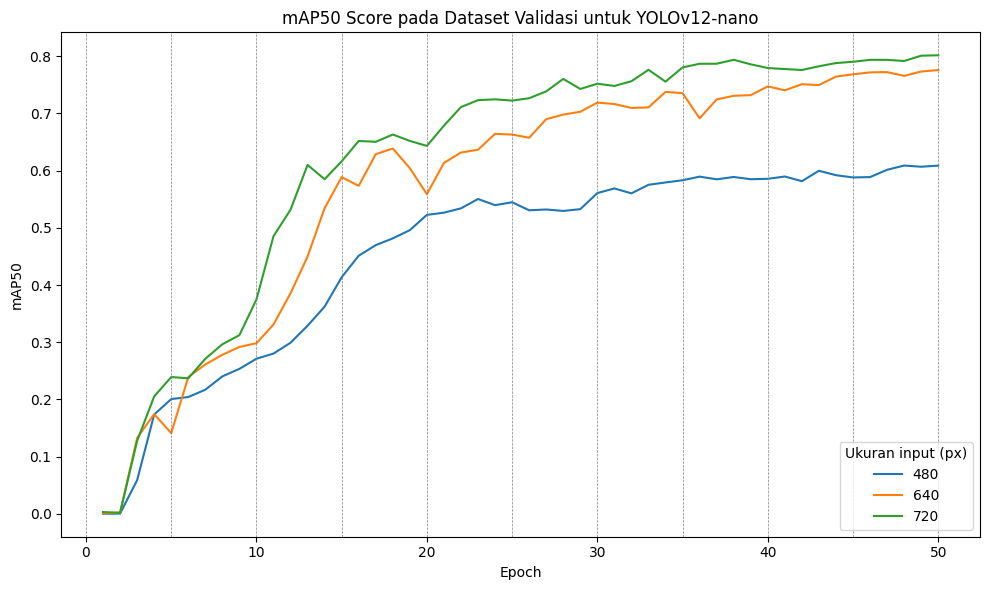

In [5]:
# Inisialisasi plot
fig = plt.figure(figsize=(10, 6))

# Plot data mAP50 untuk setiap ukuran input
for input_size, df in nano_train_results.items():
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=input_size)

# Tambahkan garis vertikal setiap 5 epoch
min_epoch = int(min(df['epoch']))-1
max_epoch = int(max(df['epoch']))
for x in range(min_epoch, max_epoch + 1, 5):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

# Tambahkan informasi pada setiap plot
plt.xlabel('Epoch')
plt.ylabel('mAP50')
plt.title('mAP50 Score pada Dataset Validasi untuk YOLOv12-nano')
plt.legend(title='Ukuran input (px)', loc='lower right')

# Atur ticks pada sumbu X setiap 10 epoch
plt.xticks(range(min_epoch, max_epoch + 1, 10))

# Tampilkan plot
plt.tight_layout()
plt.show()


Berdasarkan nilai mAP50 pada data validasi yang dicek setiap epochnya. Pada model YOLOv12-nano, peningkatan yang signifikan terjadi dari ukuran input 480x480 ke 640x640, namun peningkatan tidak terlalu signifikan pada model dengan ukuran input 640x640 ke 720x720.

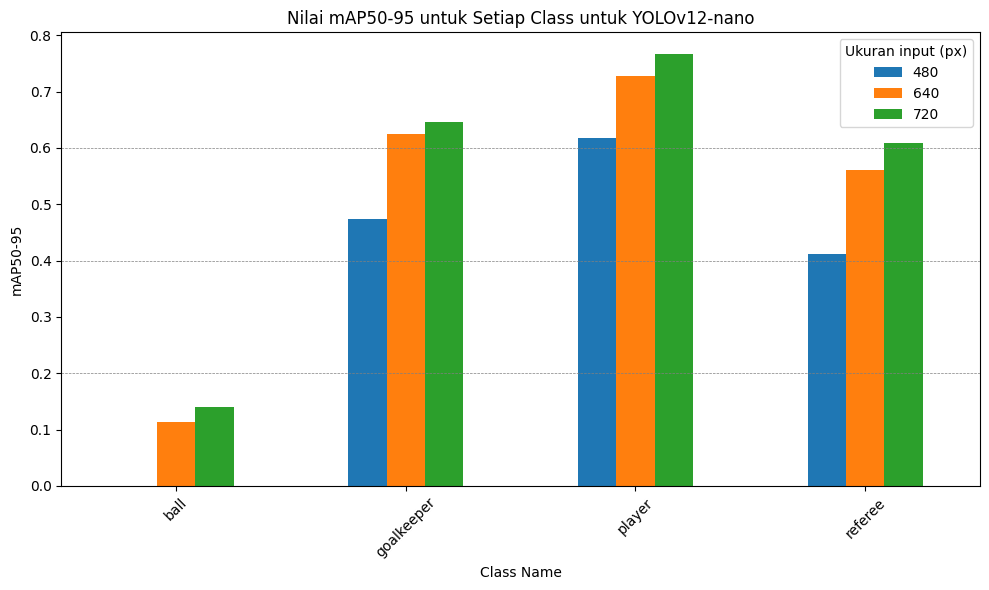

In [6]:
# Ambil data dan nilai mAP50
classes = nano_test_results['480']['Class Name']
model_names = list(nano_test_results.keys())
mAP50_95_values = {model: df['mAP50-95'].values for model, df in nano_test_results.items()}

# Buat dataframe dari nilai mAP50-95
data = pd.DataFrame(mAP50_95_values, index=classes)

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(10, 6))

# Garis vertikal
for y in [0.2, 0.4, 0.6]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# Plot stacked barchart
data.plot(kind='bar', ax=ax)

# Tambahkan informasi pada graf
ax.set_xlabel('Class Name')
ax.set_ylabel('mAP50-95')
ax.set_title('Nilai mAP50-95 untuk Setiap Class untuk YOLOv12-nano')


# Print plot
plt.xticks(rotation=45)
plt.legend(title='Ukuran input (px)')
plt.tight_layout()
plt.show()

Hasil tabel diatas adalah hasil nilai mAP50-95 pada data uji. Dapat dilihat bahwa kelas *ball* tidak dapat dideteksi sama sekali pada model dengan ukuran input 480x480. Model dengan ukuran input 640x640 dan 720x720 berhasil mendeteksi *ball*, tetapi masih sangat buruk.

Jika melihat pada kelas lain, peningkatan performa deteksi yang signifikan terjadi pada model dengan ukuran input 480x480 ke model dengan ukuran 640x640. Bedasarkan hal tersebut, meningkatkan ukuran input dapat meningkatkan performa deteksi model tetapi dengan *diminishing return*.

# YOLOv12s - Small

In [14]:
# Buat objek model untuk setiap ukuran input berbeda
small_models = {
    '480' : YOLOv12Model('s', 480, 50),
    '640' : YOLOv12Model('s', 640, 50),
    '720' : YOLOv12Model('s', 720, 50)
}

## Train small model - 480 x 480

In [15]:
small_models['480'].train(data_path)
small_models['480'].validate()
small_models['480'].save_metrics()
small_models['480']._delete_model()

Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12s.pt, data=/kaggle/working/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=480, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=small-480, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning /kaggle/working/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to runs/detect/small-480/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 4 dataloader workers
Logging results to runs/detect/small-480
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.56G      1.906      3.012     0.9196        245        480: 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         49       1174      0.652      0.152      0.162     0.0742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.9G      1.667      1.144     0.8541        307        480: 100%|██████████| 25/25 [00:05<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]

                   all         49       1174      0.431      0.195      0.127      0.057



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       2.9G      1.656       1.12     0.8527        267        480: 100%|██████████| 25/25 [00:05<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.42it/s]

                   all         49       1174       0.19      0.245      0.172     0.0878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.9G      1.606     0.9671     0.8496        308        480: 100%|██████████| 25/25 [00:05<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.17it/s]

                   all         49       1174      0.468      0.374      0.225     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.9G      1.606     0.8942     0.8455        267        480: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]

                   all         49       1174      0.541      0.363      0.275      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.9G      1.532     0.8506     0.8405        407        480: 100%|██████████| 25/25 [00:05<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]

                   all         49       1174      0.684       0.44      0.409      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.9G      1.547     0.8245     0.8449        271        480: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]

                   all         49       1174      0.454      0.448      0.202      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.9G      1.496     0.8296     0.8365        366        480: 100%|██████████| 25/25 [00:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]

                   all         49       1174      0.756      0.489      0.537      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.9G      1.488     0.8024     0.8313        272        480: 100%|██████████| 25/25 [00:05<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]

                   all         49       1174       0.75      0.455      0.492      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.9G      1.449     0.7699     0.8329        295        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]

                   all         49       1174      0.587      0.529      0.568      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.9G      1.426     0.7784     0.8325        339        480: 100%|██████████| 25/25 [00:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]

                   all         49       1174      0.666      0.508      0.549      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.9G      1.457     0.8032     0.8266        388        480: 100%|██████████| 25/25 [00:04<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]

                   all         49       1174      0.659      0.396      0.469      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.9G      1.408     0.8162     0.8286        454        480: 100%|██████████| 25/25 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.89it/s]

                   all         49       1174      0.858      0.513      0.615      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       2.9G      1.377     0.7675     0.8139        336        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.46it/s]

                   all         49       1174      0.678      0.424      0.479      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       2.9G      1.346     0.7048      0.826        324        480: 100%|██████████| 25/25 [00:04<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]

                   all         49       1174      0.803       0.54      0.589      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.9G      1.334     0.6982      0.817        425        480: 100%|██████████| 25/25 [00:05<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]

                   all         49       1174      0.877      0.545      0.641      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       2.9G      1.275     0.6591     0.8181        294        480: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         49       1174      0.632        0.6      0.644      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       2.9G      1.287     0.6619      0.813        281        480: 100%|██████████| 25/25 [00:05<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.17it/s]

                   all         49       1174      0.797       0.59       0.64      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.9G      1.262     0.6446     0.8122        404        480: 100%|██████████| 25/25 [00:05<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

                   all         49       1174      0.719      0.549       0.64      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.9G      1.266     0.6371     0.8046        323        480: 100%|██████████| 25/25 [00:05<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.36it/s]

                   all         49       1174      0.712      0.539      0.642      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.9G      1.313     0.6535     0.8123        341        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         49       1174      0.795      0.593       0.64      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.9G      1.243     0.6323     0.8102        280        480: 100%|██████████| 25/25 [00:05<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]

                   all         49       1174      0.714      0.538      0.632      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.9G      1.237     0.6202      0.807        296        480: 100%|██████████| 25/25 [00:05<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]

                   all         49       1174      0.795      0.552      0.637      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.9G      1.221     0.6239     0.8073        152        480: 100%|██████████| 25/25 [00:05<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]

                   all         49       1174      0.861      0.606      0.679      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.9G      1.282     0.6364     0.8102        308        480: 100%|██████████| 25/25 [00:05<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.24it/s]

                   all         49       1174      0.858      0.591      0.673      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.9G       1.27     0.6254      0.806        343        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.09it/s]

                   all         49       1174      0.874      0.589      0.675       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.9G      1.162     0.5858     0.8082        194        480: 100%|██████████| 25/25 [00:05<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]

                   all         49       1174      0.786      0.591      0.672      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.9G      1.169     0.5902     0.8019        313        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.28it/s]

                   all         49       1174      0.853      0.598      0.657      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.9G      1.204     0.5958     0.8018        260        480: 100%|██████████| 25/25 [00:05<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]

                   all         49       1174      0.829      0.628      0.681      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.9G      1.216     0.5992     0.8034        336        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]

                   all         49       1174      0.847      0.614      0.687      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.9G      1.188     0.5768      0.805        352        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]

                   all         49       1174      0.719      0.594      0.658      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.9G      1.193     0.5794     0.8011        427        480: 100%|██████████| 25/25 [00:05<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.05it/s]

                   all         49       1174       0.91      0.578      0.672      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.9G      1.178     0.5669     0.8019        202        480: 100%|██████████| 25/25 [00:05<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]

                   all         49       1174      0.913      0.608       0.71      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.9G      1.151     0.5594     0.8013        409        480: 100%|██████████| 25/25 [00:05<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]

                   all         49       1174      0.828      0.655      0.703      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.9G      1.112     0.5455     0.7991        254        480: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]

                   all         49       1174      0.784      0.673      0.715      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.9G      1.076     0.5327     0.8012        390        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.36it/s]

                   all         49       1174      0.891      0.637      0.722      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       2.9G      1.092     0.5302     0.7963        353        480: 100%|██████████| 25/25 [00:05<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]

                   all         49       1174      0.809      0.652      0.724      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.9G      1.073      0.527     0.8004        206        480: 100%|██████████| 25/25 [00:05<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]

                   all         49       1174      0.802      0.621      0.702      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.9G      1.095     0.5437     0.7979        255        480: 100%|██████████| 25/25 [00:04<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.43it/s]

                   all         49       1174      0.913      0.631      0.709      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       2.9G       1.09     0.5327     0.7999        380        480: 100%|██████████| 25/25 [00:05<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

                   all         49       1174      0.894      0.652      0.722       0.46


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       2.9G      1.029     0.5095     0.8038        235        480: 100%|██████████| 25/25 [00:05<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]

                   all         49       1174      0.871      0.564      0.668      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.9G     0.9826     0.4958     0.7969        221        480: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.61it/s]

                   all         49       1174      0.855      0.655      0.713      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       2.9G     0.9607     0.4829     0.7968        228        480: 100%|██████████| 25/25 [00:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.40it/s]

                   all         49       1174      0.934      0.632      0.714      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.9G     0.9699      0.486     0.7974        226        480: 100%|██████████| 25/25 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]

                   all         49       1174      0.915      0.629      0.704      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       2.9G     0.9577     0.4777      0.798        225        480: 100%|██████████| 25/25 [00:04<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.38it/s]

                   all         49       1174      0.827      0.622      0.696      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       2.9G     0.9286     0.4696     0.7943        233        480: 100%|██████████| 25/25 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.42it/s]

                   all         49       1174      0.849      0.625      0.705      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.9G     0.9469     0.4679     0.7965        222        480: 100%|██████████| 25/25 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]

                   all         49       1174      0.876      0.629      0.698      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.9G     0.9364     0.4668     0.7949        229        480: 100%|██████████| 25/25 [00:04<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]

                   all         49       1174       0.86      0.632      0.696      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       2.9G     0.9256     0.4625     0.7906        231        480: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]

                   all         49       1174      0.861      0.642      0.707      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       2.9G     0.9185     0.4615     0.7878        229        480: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]

                   all         49       1174      0.901      0.643      0.712      0.462



50 epochs completed in 0.088 hours.
Optimizer stripped from runs/detect/small-480/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/small-480/weights/best.pt, 18.9MB

Validating runs/detect/small-480/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


                   all         49       1174      0.812      0.655      0.724      0.463
                  ball         45         45       0.69      0.133      0.172     0.0507
            goalkeeper         38         39      0.881      0.757       0.91      0.582
                player         49        973      0.899        0.9      0.954      0.679
               referee         49        117       0.78      0.829      0.861      0.538


invalid value encountered in less
invalid value encountered in less


Speed: 0.3ms preprocess, 4.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/small-480
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


                   all         49       1174       0.81      0.656      0.727      0.467
                  ball         45         45      0.688      0.133      0.185     0.0594
            goalkeeper         38         39      0.881      0.759      0.909      0.583
                player         49        973        0.9      0.902      0.955      0.688
               referee         49        117      0.771      0.829      0.859       0.54


invalid value encountered in less
invalid value encountered in less


Speed: 4.4ms preprocess, 10.9ms inference, 0.0ms loss, 30.6ms postprocess per image
Results saved to runs/detect/small-4802
Metrics saved to /kaggle/working/runs/detect/small-480/test_results.txt


## Train small model - 640 x 640

In [16]:
small_models['640'].train(data_path)
small_models['640'].validate()
small_models['640'].save_metrics()
small_models['640']._delete_model()

Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12s.pt, data=/kaggle/working/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=small-640, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning /kaggle/working/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to runs/detect/small-640/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/small-640
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.75G      1.519      2.693     0.9034        249        640: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         49       1174      0.901       0.19      0.191     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.35G      1.336      1.076     0.8634        311        640: 100%|██████████| 25/25 [00:08<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         49       1174      0.731      0.243      0.221      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.35G      1.336      1.012     0.8588        269        640: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

                   all         49       1174      0.173      0.258      0.204      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.35G      1.367     0.9955     0.8602        317        640: 100%|██████████| 25/25 [00:08<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         49       1174      0.645      0.371      0.385      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.35G      1.324     0.8358     0.8557        270        640: 100%|██████████| 25/25 [00:08<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         49       1174      0.782      0.506      0.568      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.35G      1.405     0.8129     0.8666        416        640: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         49       1174      0.716      0.612      0.623      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.35G      1.277      0.739     0.8487        276        640: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         49       1174      0.661      0.667      0.644      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.35G      1.222     0.7054      0.839        372        640: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         49       1174      0.693      0.618      0.585      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.35G      1.203     0.6915     0.8461        280        640: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         49       1174      0.739      0.631      0.696      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.35G       1.18     0.6567      0.845        301        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         49       1174      0.859      0.576       0.69      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.35G      1.143     0.6582     0.8426        342        640: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         49       1174      0.781       0.71      0.721      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.35G      1.246     0.6674     0.8384        391        640: 100%|██████████| 25/25 [00:08<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

                   all         49       1174      0.755      0.666      0.701      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.35G      1.101      0.637     0.8325        466        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         49       1174      0.824      0.712      0.751      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.35G      1.148     0.6727     0.8323        344        640: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         49       1174      0.862      0.654      0.691      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.35G      1.122     0.6427     0.8328        331        640: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         49       1174      0.798      0.681       0.73      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.35G      1.061      0.593     0.8225        439        640: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

                   all         49       1174      0.804      0.711      0.743      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.35G      1.071     0.5891     0.8261        297        640: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         49       1174      0.804      0.691      0.738      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.35G      1.083     0.5812     0.8272        290        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

                   all         49       1174      0.882      0.755      0.779       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.35G      1.088      0.572     0.8251        420        640: 100%|██████████| 25/25 [00:08<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         49       1174      0.829      0.732       0.77      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.35G       1.12     0.5948     0.8266        333        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         49       1174      0.738      0.692      0.733      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.35G      1.034     0.5502     0.8206        348        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         49       1174       0.84      0.705      0.766      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.35G      1.034     0.5686     0.8247        291        640: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         49       1174      0.817      0.716      0.767      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.35G      1.063     0.5703     0.8194        318        640: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         49       1174      0.874      0.729      0.784      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.35G      1.064     0.5692     0.8249        152        640: 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         49       1174       0.86      0.717      0.765       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.35G      1.023     0.5527     0.8189        315        640: 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         49       1174      0.865      0.722      0.777      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.35G      1.009     0.5375      0.817        350        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         49       1174      0.919      0.742      0.782      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.35G     0.9583      0.513     0.8214        196        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         49       1174      0.863      0.767       0.78       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.35G     0.9794     0.5171     0.8106        321        640: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         49       1174      0.916      0.719      0.779      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.35G     0.9823     0.5153     0.8159        262        640: 100%|██████████| 25/25 [00:08<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.59it/s]

                   all         49       1174      0.883      0.731      0.777      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.35G     0.9954     0.5287     0.8164        341        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         49       1174      0.896      0.717      0.793      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.35G      0.974     0.5182     0.8153        360        640: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         49       1174      0.844      0.744      0.771      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.35G     0.9874     0.5236     0.8137        440        640: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

                   all         49       1174      0.902      0.685      0.779      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.35G     0.9469     0.5046     0.8131        202        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.61it/s]

                   all         49       1174      0.916      0.733      0.801      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.35G     0.9387     0.5013     0.8106        421        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         49       1174      0.929      0.717      0.789      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.35G     0.9104     0.4834     0.8091        258        640: 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]

                   all         49       1174      0.885      0.744      0.795      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.35G     0.8976     0.4719     0.8122        410        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]

                   all         49       1174      0.903      0.753      0.765       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.35G     0.9172     0.4871      0.806        365        640: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

                   all         49       1174      0.911      0.731      0.775      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.35G     0.9061     0.4772     0.8128        208        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         49       1174      0.905      0.748      0.792      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.35G      0.923     0.4787     0.8098        258        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         49       1174      0.921      0.754      0.805      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.35G     0.8918     0.4604     0.8065        400        640: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         49       1174      0.909      0.751      0.796       0.55


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.35G     0.8415     0.4435     0.8092        238        640: 100%|██████████| 25/25 [00:09<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]

                   all         49       1174      0.911      0.762      0.804      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.35G     0.8141      0.432     0.8087        233        640: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

                   all         49       1174      0.916      0.761      0.799      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.35G     0.8179     0.4341     0.8068        228        640: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         49       1174      0.904      0.753      0.811      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.35G     0.8235     0.4297     0.8036        236        640: 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         49       1174      0.903      0.718      0.796      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.35G     0.8084     0.4272     0.8003        228        640: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         49       1174      0.919      0.728      0.796      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.35G      0.771     0.4054     0.8033        236        640: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         49       1174      0.934      0.733      0.802      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.35G     0.7904     0.4122     0.8044        222        640: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

                   all         49       1174      0.944      0.735      0.805       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.35G     0.7758     0.4046     0.8016        234        640: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.55it/s]

                   all         49       1174      0.931      0.763      0.809      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.35G     0.7657     0.3985     0.7979        238        640: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]

                   all         49       1174      0.929      0.759       0.81      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.35G     0.7616     0.3987     0.8011        232        640: 100%|██████████| 25/25 [00:08<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]

                   all         49       1174      0.927      0.751      0.813      0.568



50 epochs completed in 0.139 hours.
Optimizer stripped from runs/detect/small-640/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/small-640/weights/best.pt, 18.9MB

Validating runs/detect/small-640/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


                   all         49       1174      0.945      0.735      0.805      0.569
                  ball         45         45      0.934      0.317      0.366      0.164
            goalkeeper         38         39      0.899      0.821      0.927      0.696
                player         49        973      0.983      0.939      0.985      0.788
               referee         49        117      0.962      0.864      0.942      0.627


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 10.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/small-640
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


                   all         49       1174      0.945      0.735      0.806      0.572
                  ball         45         45      0.934      0.317      0.366      0.164
            goalkeeper         38         39      0.897      0.821      0.929      0.688
                player         49        973      0.987       0.94      0.985      0.801
               referee         49        117      0.962      0.864      0.942      0.633


invalid value encountered in less
invalid value encountered in less


Speed: 4.9ms preprocess, 16.7ms inference, 0.0ms loss, 27.2ms postprocess per image
Results saved to runs/detect/small-6402
Metrics saved to /kaggle/working/runs/detect/small-640/test_results.txt


## Train small model - 720 x 720

In [17]:
small_models['720'].train(data_path)
small_models['720'].validate()
small_models['720'].save_metrics()
small_models['720']._delete_model()

Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12s.pt, data=/kaggle/working/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=720, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=small-720, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning /kaggle/working/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to runs/detect/small-720/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 736 train, 736 val
Using 4 dataloader workers
Logging results to runs/detect/small-720
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.02G      1.401      2.613     0.9123        249        736: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         49       1174      0.934        0.2      0.222       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.03G      1.171      1.041     0.8632        312        736: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         49       1174      0.235      0.217      0.233      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.03G      1.203      0.913     0.8601        272        736: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]

                   all         49       1174      0.625      0.524      0.437       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.03G      1.225     0.8244     0.8626        318        736: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

                   all         49       1174      0.811      0.542      0.624       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.03G       1.31     0.8132     0.8698        273        736: 100%|██████████| 25/25 [00:13<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.90it/s]

                   all         49       1174      0.712      0.587       0.61      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.03G       1.18     0.7377     0.8645        417        736: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         49       1174      0.835      0.612      0.674      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.03G      1.144     0.7184     0.8608        278        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         49       1174      0.769      0.632      0.687      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.03G      1.102     0.6716     0.8479        375        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         49       1174       0.74      0.687        0.7      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.03G      1.121     0.6971     0.8468        283        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.99it/s]

                   all         49       1174      0.776      0.636      0.693      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.03G       1.02     0.6492     0.8411        303        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.01it/s]

                   all         49       1174      0.805      0.674      0.747      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.03G     0.9867     0.5982     0.8397        342        736: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         49       1174      0.828      0.701       0.75      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.03G      1.083     0.6184     0.8414        392        736: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

                   all         49       1174      0.822       0.64      0.704      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.03G      1.072     0.6127     0.8476        468        736: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         49       1174      0.826      0.657      0.725      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.03G      1.042     0.5881     0.8383        348        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         49       1174       0.86      0.709       0.76       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.03G      1.039     0.5728     0.8431        333        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         49       1174      0.848      0.686      0.774      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.03G      1.026     0.5548     0.8307        441        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

                   all         49       1174      0.923      0.715      0.799      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.03G      1.005     0.5515      0.843        299        736: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         49       1174      0.839      0.712      0.784      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.03G       1.03     0.5678     0.8398        293        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all         49       1174        0.9      0.735      0.802      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.03G     0.9719     0.5447     0.8294        421        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         49       1174      0.884      0.735      0.802      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.03G      1.014     0.5557     0.8299        337        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

                   all         49       1174       0.81      0.733      0.783       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.03G      1.006     0.5565     0.8281        352        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         49       1174      0.825      0.737      0.794      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.03G      1.034     0.5542     0.8343        293        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         49       1174       0.81      0.737      0.785      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.03G     0.9935     0.5242     0.8304        321        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all         49       1174       0.87      0.705      0.782      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.03G     0.9873     0.5233     0.8276        152        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]

                   all         49       1174      0.804       0.75      0.789      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.03G     0.9474     0.5072     0.8261        317        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         49       1174      0.871      0.738      0.813      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.03G     0.8879     0.4778     0.8183        351        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all         49       1174      0.882      0.794      0.832      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.03G     0.8952     0.4894     0.8251        196        736: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]

                   all         49       1174      0.874      0.792       0.83      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.03G     0.9015     0.4844     0.8183        322        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         49       1174      0.844      0.775      0.819      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.03G     0.9057     0.4866     0.8202        262        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         49       1174      0.815      0.772      0.785      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.03G     0.9061     0.4849     0.8214        342        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

                   all         49       1174      0.855      0.742      0.803      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.03G      0.881     0.4713     0.8158        361        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         49       1174      0.886      0.726      0.816      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.03G     0.9053     0.4821     0.8193        442        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]

                   all         49       1174      0.871      0.759      0.813      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.03G     0.9184     0.4857     0.8245        202        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         49       1174      0.843       0.78      0.819      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.03G     0.8809     0.4663     0.8193        424        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         49       1174      0.881      0.782      0.835      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.03G     0.8475     0.4506     0.8185        259        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]

                   all         49       1174       0.88      0.784      0.827      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.03G     0.8389     0.4476      0.817        412        736: 100%|██████████| 25/25 [00:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         49       1174      0.843      0.787      0.823      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.03G     0.8512     0.4504     0.8169        367        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         49       1174      0.926      0.731      0.813      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.03G     0.8642     0.4598     0.8212        210        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]

                   all         49       1174      0.875      0.781      0.836      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.03G     0.9053     0.4769      0.821        257        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

                   all         49       1174      0.824       0.79      0.814      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.03G     0.8655     0.4489      0.814        403        736: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         49       1174      0.893      0.784      0.826      0.563


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.03G     0.8072     0.4284      0.816        239        736: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]

                   all         49       1174      0.868      0.781      0.825      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.03G     0.7672     0.4111     0.8147        234        736: 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         49       1174      0.932       0.77      0.826      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.03G     0.7625     0.4038      0.816        229        736: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         49       1174      0.934      0.756      0.824      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.03G     0.7656     0.4016     0.8156        237        736: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         49       1174      0.871      0.768      0.819      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.03G     0.7529     0.4023     0.8109        228        736: 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

                   all         49       1174      0.929      0.772      0.834      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.03G     0.7365     0.3928     0.8136        236        736: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]

                   all         49       1174      0.928      0.767      0.839      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.03G     0.7456     0.3935     0.8102        222        736: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

                   all         49       1174      0.872      0.792      0.836      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.03G     0.7399       0.39      0.806        234        736: 100%|██████████| 25/25 [00:13<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.04it/s]

                   all         49       1174      0.912      0.791      0.839      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.03G     0.7227     0.3842     0.8091        238        736: 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         49       1174      0.892      0.786      0.833      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.03G     0.7265     0.3847     0.8092        232        736: 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         49       1174      0.887       0.78      0.833       0.59



50 epochs completed in 0.210 hours.
Optimizer stripped from runs/detect/small-720/weights/last.pt, 19.0MB
Optimizer stripped from runs/detect/small-720/weights/best.pt, 19.0MB

Validating runs/detect/small-720/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


                   all         49       1174      0.873      0.792      0.837      0.599
                  ball         45         45      0.872      0.356      0.438      0.193
            goalkeeper         38         39      0.847      0.923       0.96      0.747
                player         49        973      0.947      0.965      0.989        0.8
               referee         49        117      0.824      0.923       0.96      0.657


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 10.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/small-720
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


                   all         49       1174      0.874      0.792      0.838      0.604
                  ball         45         45      0.871      0.356      0.434      0.199
            goalkeeper         38         39      0.846      0.923      0.969      0.742
                player         49        973       0.95      0.965      0.989      0.818
               referee         49        117       0.83      0.923       0.96      0.659


invalid value encountered in less
invalid value encountered in less


Speed: 5.9ms preprocess, 21.5ms inference, 0.0ms loss, 27.5ms postprocess per image
Results saved to runs/detect/small-7202
Metrics saved to /kaggle/working/runs/detect/small-720/test_results.txt


## YOLOv12s - Small Evaluation

In [7]:
# Load hasil pelatihan
small_train_results = {
    '480' : pd.read_csv('/kaggle/working/runs/detect/small-480/results.csv'),
    '640' : pd.read_csv('/kaggle/working/runs/detect/small-640/results.csv'),
    '720' : pd.read_csv('/kaggle/working/runs/detect/small-720/results.csv'),
}

# Load hasil testing
small_test_results = {
    '480' : pd.read_csv('/kaggle/working/runs/detect/small-480/test_results.txt', sep='\t'),
    '640' : pd.read_csv('/kaggle/working/runs/detect/small-640/test_results.txt', sep='\t'),
    '720' : pd.read_csv('/kaggle/working/runs/detect/small-720/test_results.txt', sep='\t'),
}

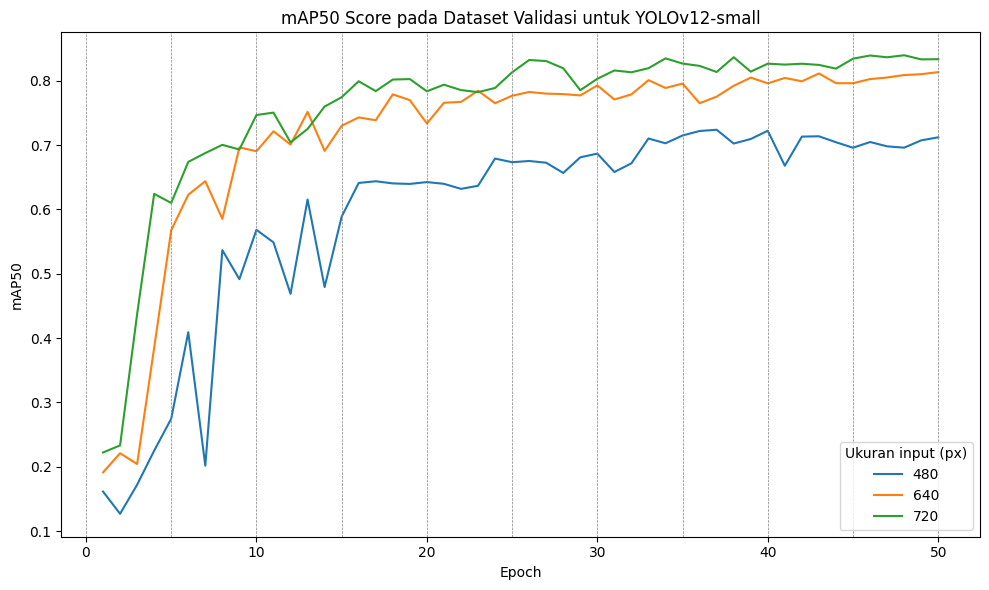

In [8]:
# Inisialisasi plot
fig = plt.figure(figsize=(10, 6))

# Plot data mAP50 untuk setiap ukuran input
for input_size, df in small_train_results.items():
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=input_size)

# Tambahkan garis vertikal setiap 5 epoch
min_epoch = int(min(df['epoch']))-1
max_epoch = int(max(df['epoch']))
for x in range(min_epoch, max_epoch + 1, 5):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

# Tambahkan informasi pada setiap plot
plt.xlabel('Epoch')
plt.ylabel('mAP50')
plt.title('mAP50 Score pada Dataset Validasi untuk YOLOv12-small')
plt.legend(title='Ukuran input (px)', loc='lower right')

# Atur ticks pada sumbu X setiap 10 epoch
plt.xticks(range(min_epoch, max_epoch + 1, 10))

# Tampilkan plot
plt.tight_layout()
plt.show()


Pada proses pelatihan model YOLOv12-small, peningkatan performa antara model dengan ukuran input 480x480 dengan model 640x640 tidak terlalu se-signifikan seperti yang terjadi pada YOLOv12-nano. Akurasi mAP50 pada ketiga model juga memiliki peningkatan yang signifikan.

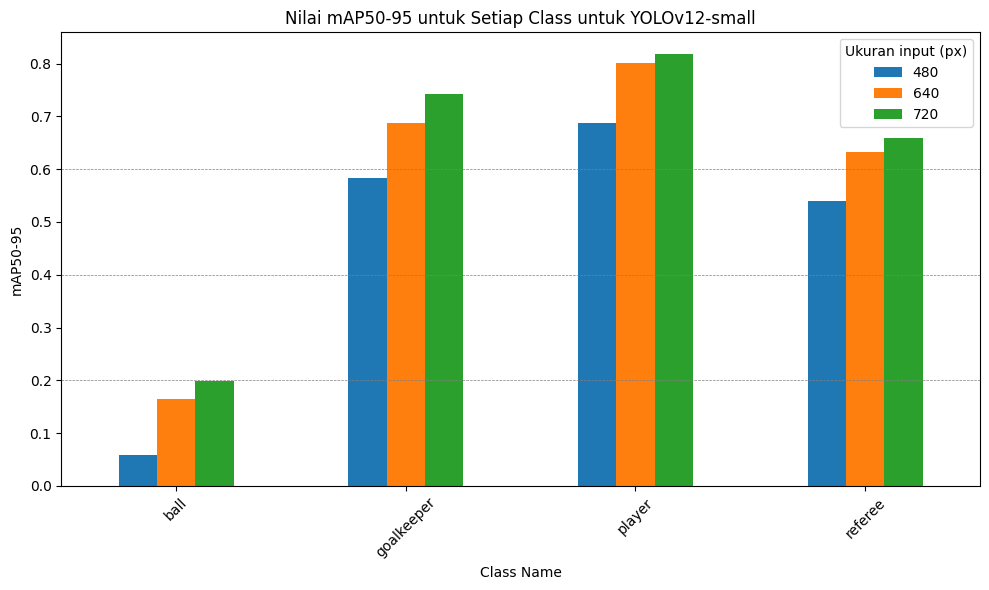

In [9]:
# Ambil data dan nilai mAP50
classes = small_test_results['480']['Class Name']
model_names = list(small_test_results.keys())
mAP50_95_values = {model: df['mAP50-95'].values for model, df in small_test_results.items()}

# Buat dataframe dari nilai mAP50-95
data = pd.DataFrame(mAP50_95_values, index=classes)

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(10, 6))

# Garis vertikal
for y in [0.2, 0.4, 0.6]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# Plot stacked barchart
data.plot(kind='bar', ax=ax)

# Tambahkan informasi pada graf
ax.set_xlabel('Class Name')
ax.set_ylabel('mAP50-95')
ax.set_title('Nilai mAP50-95 untuk Setiap Class untuk YOLOv12-small')


# Print plot
plt.xticks(rotation=45)
plt.legend(title='Ukuran input (px)')
plt.tight_layout()
plt.show()

Model YOLOv12-small dengan ukuran input 480x480 berhasil mendeteksi bola dengan mAP50-95 kurang dari 0.1. Pada data uji, perbedaan performa antara ukuran input 480x480 dengan 640x640 masih terlihat cukup signifikan. Ketiga YOLOv12-small memiliki peningkatan akurasi pada seluruh kelas dibandingkan YOLOv12-nano. Hal tersebut membuktikan bahwa ukuran model sangat berpengaruh terhadap akurasi deteksi model.

# YOLOv12m - Medium

In [21]:
# Buat objek model untuk setiap ukuran input berbeda
medium_models = {
    '480' : YOLOv12Model('m', 480, 50),
    '640' : YOLOv12Model('m', 640, 50),
    '720' : YOLOv12Model('m', 720, 50)
}

## Train Medium Model - 480 x 480

In [22]:
medium_models['480'].train(data_path)
medium_models['480'].validate()
medium_models['480'].save_metrics()
medium_models['480']._delete_model()

Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12m.pt, data=/kaggle/working/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=480, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=medium-480, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

train: Scanning /kaggle/working/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to runs/detect/medium-480/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 123 weight(decay=0.0), 130 weight(decay=0.00046875), 129 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 480 train, 480 val
Using 4 dataloader workers
Logging results to runs/detect/medium-480
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       4.6G      1.739      2.874     0.8932        245        480: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         49       1174      0.072      0.237     0.0547     0.0252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.31G      1.452     0.9631     0.8401        307        480: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

                   all         49       1174      0.174      0.283      0.199     0.0939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.31G      1.541     0.9487     0.8321        267        480: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]

                   all         49       1174      0.458      0.339      0.327      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.31G      1.678     0.9894     0.8531        308        480: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         49       1174      0.396       0.44      0.382       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.31G      1.762     0.9585     0.8635        267        480: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         49       1174      0.265      0.232      0.198     0.0936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.31G      1.495     0.8437     0.8485        407        480: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         49       1174      0.529      0.442      0.433      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.31G      1.545     0.8538     0.8501        271        480: 100%|██████████| 25/25 [00:09<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         49       1174       0.73      0.424      0.489      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.31G      1.438     0.8757      0.834        366        480: 100%|██████████| 25/25 [00:09<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         49       1174      0.711      0.407       0.48      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.31G      1.397     0.8042      0.836        272        480: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         49       1174      0.574      0.451      0.476      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.31G       1.36     0.7408     0.8324        295        480: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         49       1174      0.757      0.449       0.52       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.31G       1.36     0.7802     0.8358        339        480: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         49       1174      0.584      0.531      0.557      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.31G      1.465     0.7925     0.8359        388        480: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.54it/s]

                   all         49       1174      0.713      0.443      0.449      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.31G      1.341     0.7504     0.8318        454        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         49       1174      0.791      0.567      0.606      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.31G      1.277     0.6916     0.8144        336        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

                   all         49       1174      0.764       0.53      0.595      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.31G      1.325     0.6867     0.8293        324        480: 100%|██████████| 25/25 [00:09<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all         49       1174      0.529      0.436      0.511      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.31G      1.436     0.7267     0.8272        425        480: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         49       1174      0.817      0.554      0.624      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.31G      1.314     0.6735     0.8257        294        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.81it/s]

                   all         49       1174      0.771      0.563      0.655      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.31G      1.252     0.6421     0.8162        281        480: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         49       1174      0.875      0.561       0.64      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.31G      1.224     0.6327     0.8158        404        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         49       1174       0.87      0.624      0.693      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.31G      1.243     0.6212     0.8064        323        480: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         49       1174      0.801      0.544      0.659      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.31G      1.194     0.6126     0.8089        341        480: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         49       1174      0.815      0.572      0.664      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.31G      1.176     0.6042     0.8103        280        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         49       1174       0.77      0.612      0.668      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.31G      1.149     0.5847     0.8058        296        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         49       1174       0.75      0.667      0.709      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.31G      1.151     0.5804     0.8099        152        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         49       1174      0.756      0.609      0.683      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.31G      1.201     0.5971     0.8098        308        480: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         49       1174      0.848      0.593      0.689      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.31G      1.186     0.5967     0.8055        343        480: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         49       1174      0.844      0.612      0.697       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.31G      1.095      0.562     0.8096        194        480: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

                   all         49       1174      0.877      0.583       0.69      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.31G      1.108     0.5681      0.803        313        480: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.80it/s]

                   all         49       1174      0.863      0.601      0.695      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.31G      1.123     0.5583     0.8021        260        480: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         49       1174      0.695      0.619      0.681      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.31G      1.099     0.5469     0.8036        336        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]

                   all         49       1174        0.7      0.587      0.681       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.31G      1.073     0.5275     0.8031        352        480: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.95it/s]

                   all         49       1174      0.754      0.674      0.722      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.31G      1.119     0.5542     0.8016        427        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         49       1174      0.765      0.663      0.706      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.31G      1.106     0.5619     0.8021        202        480: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         49       1174      0.771      0.642      0.705      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.31G      1.071     0.5414     0.8026        409        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         49       1174      0.682      0.663      0.703      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.31G      1.046     0.5318     0.8001        254        480: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         49       1174      0.759      0.655      0.732      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.31G      1.007     0.5171     0.8013        390        480: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         49       1174      0.819      0.635      0.711      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.31G      1.028     0.5172     0.7977        353        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all         49       1174      0.847      0.679      0.735      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.31G      1.035     0.5264     0.8011        206        480: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         49       1174      0.715      0.617      0.684       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.31G      1.044     0.5252     0.7996        255        480: 100%|██████████| 25/25 [00:09<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.85it/s]

                   all         49       1174       0.74      0.677      0.723      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.31G      1.015     0.5006     0.8018        380        480: 100%|██████████| 25/25 [00:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         49       1174        0.8      0.664      0.734      0.474


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.31G     0.9446     0.4768     0.8016        235        480: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         49       1174      0.756      0.652      0.711      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.31G     0.9163     0.4622     0.7952        221        480: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         49       1174      0.788      0.668      0.733      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.31G     0.8975     0.4576     0.7965        228        480: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         49       1174      0.819      0.661      0.731      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.31G     0.9001      0.461     0.7964        226        480: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         49       1174      0.736      0.679      0.739      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.31G     0.8831     0.4414     0.7957        225        480: 100%|██████████| 25/25 [00:08<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all         49       1174      0.786      0.667      0.742      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.31G      0.868     0.4418     0.7941        233        480: 100%|██████████| 25/25 [00:09<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]

                   all         49       1174      0.833      0.671      0.749      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.31G     0.8754     0.4372     0.7935        222        480: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         49       1174      0.823      0.673      0.749      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.31G      0.867     0.4309     0.7939        229        480: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.78it/s]

                   all         49       1174      0.822      0.672      0.749      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.31G     0.8581     0.4275     0.7895        231        480: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         49       1174      0.814      0.679      0.749      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.31G     0.8578     0.4307     0.7857        229        480: 100%|██████████| 25/25 [00:08<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         49       1174      0.796      0.687      0.749      0.506



50 epochs completed in 0.151 hours.
Optimizer stripped from runs/detect/medium-480/weights/last.pt, 40.7MB
Optimizer stripped from runs/detect/medium-480/weights/best.pt, 40.7MB

Validating runs/detect/medium-480/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


                   all         49       1174      0.796      0.686       0.75      0.506
                  ball         45         45       0.62      0.182       0.21     0.0727
            goalkeeper         38         39      0.814      0.785      0.897      0.624
                player         49        973      0.914      0.908      0.963      0.737
               referee         49        117      0.837      0.872       0.93       0.59


invalid value encountered in less
invalid value encountered in less


Speed: 0.3ms preprocess, 9.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/medium-480
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


                   all         49       1174      0.796      0.685      0.749       0.51
                  ball         45         45      0.619      0.181       0.21     0.0752
            goalkeeper         38         39      0.813      0.783      0.897      0.632
                player         49        973      0.915      0.906      0.963      0.745
               referee         49        117      0.836      0.872      0.926      0.587


invalid value encountered in less
invalid value encountered in less


Speed: 3.5ms preprocess, 18.7ms inference, 0.1ms loss, 26.8ms postprocess per image
Results saved to runs/detect/medium-4802
Metrics saved to /kaggle/working/runs/detect/medium-480/test_results.txt


## Train Medium Model - 640 x 640

In [23]:
medium_models['640'].train(data_path)
medium_models['640'].validate()
medium_models['640'].save_metrics()
medium_models['640']._delete_model()

Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12m.pt, data=/kaggle/working/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=medium-640, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

train: Scanning /kaggle/working/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to runs/detect/medium-640/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 123 weight(decay=0.0), 130 weight(decay=0.00046875), 129 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/medium-640
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.93G      1.486      2.766     0.8884        249        640: 100%|██████████| 25/25 [00:16<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         49       1174      0.442      0.202      0.215      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.1G      1.284      1.033      0.867        311        640: 100%|██████████| 25/25 [00:16<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         49       1174       0.28       0.34      0.256      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.1G      1.338     0.8749     0.8592        269        640: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]

                   all         49       1174      0.365      0.423      0.427      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.1G      1.267     0.8135     0.8501        317        640: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         49       1174      0.422      0.384      0.367      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.1G      1.357     0.7983     0.8648        270        640: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         49       1174      0.645      0.451      0.421      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.1G      1.253     0.9102     0.8557        416        640: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         49       1174      0.394      0.553      0.452      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.1G      1.189     0.8203     0.8412        276        640: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]

                   all         49       1174       0.65      0.449      0.478      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.1G      1.239     0.7709     0.8467        372        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         49       1174      0.508      0.552      0.449      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.1G      1.221     0.7394     0.8492        280        640: 100%|██████████| 25/25 [00:15<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         49       1174      0.637      0.621      0.497       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.1G       1.26     0.7235     0.8502        301        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         49       1174      0.768      0.658      0.696      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.1G      1.243     0.6905     0.8494        342        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         49       1174      0.762      0.685      0.712      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.1G      1.325     0.7205     0.8491        391        640: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         49       1174      0.599      0.582      0.599      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.1G      1.127     0.6551     0.8516        466        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         49       1174      0.745      0.525      0.598      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.1G        1.1      0.643     0.8326        344        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         49       1174      0.799      0.703      0.734      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.1G      1.147     0.6372     0.8376        331        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         49       1174      0.774      0.681      0.724      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.1G      1.084     0.6055     0.8261        439        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         49       1174      0.883      0.688       0.75      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.1G      1.034     0.5755     0.8301        297        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         49       1174      0.829      0.659      0.748      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.1G      1.105     0.5878     0.8321        290        640: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         49       1174      0.748      0.683      0.704      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.1G      1.101     0.5872     0.8277        420        640: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         49       1174      0.883      0.666      0.748      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.1G      1.054     0.5658     0.8254        333        640: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         49       1174      0.829      0.708      0.754       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.1G      1.021     0.5517     0.8213        348        640: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         49       1174      0.842      0.677      0.756      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.1G       1.03     0.5546     0.8257        291        640: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         49       1174      0.741      0.766      0.762      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.1G      1.037     0.5535     0.8199        318        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         49       1174      0.849      0.739      0.783      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.1G      1.021     0.5405     0.8253        152        640: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         49       1174       0.87      0.725      0.782      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.1G      1.006     0.5353     0.8207        315        640: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         49       1174      0.902      0.705      0.777      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.1G     0.9701     0.5206     0.8148        350        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         49       1174      0.818      0.742      0.783      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.1G     0.9431     0.4939     0.8207        196        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         49       1174      0.829      0.752      0.772      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.1G     0.9606      0.509     0.8089        321        640: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         49       1174      0.894      0.742      0.802      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.1G     0.9332     0.4936     0.8119        262        640: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         49       1174       0.86      0.772      0.808      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.1G     0.8744     0.4619     0.8022        365        640: 100%|██████████| 25/25 [00:15<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         49       1174      0.904      0.737      0.799      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.1G     0.8603     0.4545     0.8091        208        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         49       1174      0.892      0.761      0.809      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.1G     0.8915     0.4607     0.8065        258        640: 100%|██████████| 25/25 [00:16<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         49       1174      0.871      0.768      0.812      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.1G     0.8438     0.4345     0.8021        400        640: 100%|██████████| 25/25 [00:15<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

                   all         49       1174      0.906      0.759      0.819      0.569


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.1G     0.8088     0.4204     0.8074        238        640: 100%|██████████| 25/25 [00:16<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         49       1174      0.887      0.748      0.807      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.1G     0.7754     0.4089     0.8062        233        640: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         49       1174      0.901      0.745      0.806      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.1G      0.785     0.4113     0.8043        228        640: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         49       1174      0.903      0.756      0.811      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.1G     0.7904     0.4092     0.8012        236        640: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         49       1174      0.903      0.717      0.798      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.1G     0.7796     0.4097     0.7981        228        640: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         49       1174      0.912      0.752        0.8      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.1G     0.7547     0.3934     0.8014        236        640: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]

                   all         49       1174      0.881      0.761      0.806      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.1G     0.7583     0.3903      0.801        222        640: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         49       1174      0.903      0.756      0.808      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.1G     0.7387     0.3863     0.7978        234        640: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         49       1174      0.909      0.755      0.809      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.1G     0.7338     0.3788     0.7953        238        640: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         49       1174      0.894       0.77      0.811      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.1G     0.7321     0.3819     0.7983        232        640: 100%|██████████| 25/25 [00:15<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         49       1174      0.889      0.767      0.812      0.586



50 epochs completed in 0.252 hours.
Optimizer stripped from runs/detect/medium-640/weights/last.pt, 40.8MB
Optimizer stripped from runs/detect/medium-640/weights/best.pt, 40.8MB

Validating runs/detect/medium-640/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]


                   all         49       1174      0.893       0.77      0.811      0.586
                  ball         45         45      0.848      0.311      0.373      0.177
            goalkeeper         38         39      0.876      0.904      0.946      0.713
                player         49        973      0.953      0.959      0.985      0.799
               referee         49        117      0.896      0.906      0.939      0.654


invalid value encountered in less
invalid value encountered in less


Speed: 0.3ms preprocess, 18.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/medium-640
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


                   all         49       1174      0.893      0.771      0.811      0.599
                  ball         45         45      0.848      0.311      0.373      0.182
            goalkeeper         38         39      0.876      0.906      0.946      0.736
                player         49        973      0.954      0.959      0.986      0.816
               referee         49        117      0.896      0.906      0.939      0.663


invalid value encountered in less
invalid value encountered in less


Speed: 5.6ms preprocess, 35.5ms inference, 0.0ms loss, 19.0ms postprocess per image
Results saved to runs/detect/medium-6402
Metrics saved to /kaggle/working/runs/detect/medium-640/test_results.txt


## Train Medium Model - 720 x 720

In [24]:
medium_models['720'].train(data_path)
medium_models['720'].validate()
medium_models['720'].save_metrics()
medium_models['720']._delete_model()

Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12m.pt, data=/kaggle/working/football-players-detection-12/data.yaml, epochs=50, time=None, patience=100, batch=12, imgsz=720, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=medium-720, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

train: Scanning /kaggle/working/football-players-detection-12/train/labels.cache... 298 images, 0 backgrounds, 0 corrupt: 100%|██████████| 298/298 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]


Plotting labels to runs/detect/medium-720/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 


       6/50      13.1G      1.127     0.7023     0.8592        417        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         49       1174       0.57       0.56      0.548      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      13.1G      1.192     0.7994     0.8597        278        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         49       1174      0.759      0.558      0.655       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      13.1G      1.111     0.6863     0.8519        375        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         49       1174      0.666      0.474      0.558      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      13.1G      1.054     0.6892     0.8482        283        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174      0.821      0.665      0.737      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      13.1G       1.05     0.6668     0.8458        303        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         49       1174      0.759      0.663      0.688      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      13.1G      1.027     0.6053     0.8442        342        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         49       1174      0.848      0.712      0.779      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      13.1G      1.073     0.5963     0.8393        392        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         49       1174      0.852      0.714       0.77       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      13.1G     0.9822     0.5625      0.841        468        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.808      0.671      0.757      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      13.1G     0.9748     0.5466     0.8321        348        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         49       1174      0.854      0.717      0.793       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      13.1G      1.053     0.5831     0.8428        333        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.895      0.708      0.794      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      13.1G     0.9838     0.5476     0.8282        441        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.901      0.717      0.795      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      13.1G     0.9562     0.5291     0.8393        299        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.817      0.658      0.767      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      13.1G      1.005     0.5664     0.8372        293        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.887      0.714      0.801      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      13.1G      0.969      0.541     0.8302        421        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174        0.8      0.717      0.775      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      13.1G     0.9508     0.5142      0.827        337        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174      0.857      0.688      0.787      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      13.1G     0.9463     0.5155      0.825        352        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         49       1174      0.886      0.709      0.797      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      13.1G     0.9619     0.5114     0.8284        293        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174      0.837      0.714      0.793       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      13.1G      1.005     0.5342     0.8277        321        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         49       1174      0.905      0.685      0.793      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      13.1G     0.9616     0.5247     0.8268        152        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         49       1174      0.911      0.702      0.793      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      13.1G     0.9026     0.4909     0.8223        317        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174      0.854       0.72      0.796      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      13.1G     0.8885     0.4841     0.8188        351        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.786      0.777      0.809      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      13.1G     0.8966     0.4879     0.8255        196        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.889      0.786      0.835      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      13.1G     0.8907     0.4825     0.8181        322        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174      0.905      0.766      0.838      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      13.1G     0.8815     0.4645     0.8194        262        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         49       1174      0.844      0.782       0.82      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      13.1G     0.8597     0.4618     0.8173        342        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         49       1174      0.826      0.789      0.824      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      13.1G     0.8487     0.4518     0.8114        361        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174       0.88      0.734      0.825      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      13.1G       0.86     0.4569     0.8168        442        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.854      0.744      0.801      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      13.1G     0.8514     0.4577     0.8166        202        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         49       1174      0.864      0.716       0.81      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      13.1G     0.8438      0.447     0.8178        210        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.812      0.799      0.828      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      13.1G     0.8359      0.444     0.8162        257        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174      0.854      0.785      0.835      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      13.1G     0.7958     0.4208     0.8087        403        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         49       1174      0.883      0.794      0.833      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      13.1G     0.7592     0.4015     0.8125        239        736: 100%|██████████| 25/25 [00:25<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174      0.846      0.802      0.838      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      13.1G     0.7391     0.3904     0.8106        234        736: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         49       1174      0.862      0.772      0.837      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      13.1G     0.7511     0.3906     0.8138        229        736: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         49       1174      0.829      0.799      0.846      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      13.1G     0.7435     0.3843     0.8109        237        736: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         49       1174       0.85      0.808      0.848      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      13.1G     0.7236     0.3775     0.8069        228        736: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         49       1174      0.813       0.85      0.859      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      13.1G     0.7151     0.3754     0.8102        236        736: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         49       1174       0.84      0.817      0.853      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      13.1G     0.7204     0.3746     0.8053        222        736: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.842       0.81      0.848      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      13.1G     0.7094     0.3659     0.8008        234        736: 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.862      0.816      0.854      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      13.1G     0.6932     0.3585     0.8048        238        736: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         49       1174      0.838      0.814      0.848      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      13.1G     0.6946     0.3603     0.8042        232        736: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         49       1174      0.867      0.812      0.848      0.604



50 epochs completed in 0.384 hours.
Optimizer stripped from runs/detect/medium-720/weights/last.pt, 40.8MB
Optimizer stripped from runs/detect/medium-720/weights/best.pt, 40.8MB

Validating runs/detect/medium-720/weights/best.pt...
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


                   all         49       1174      0.848      0.822      0.854      0.608
                  ball         45         45      0.815        0.4      0.502       0.19
            goalkeeper         38         39      0.801      0.927      0.947      0.747
                player         49        973      0.932       0.97       0.99      0.808
               referee         49        117      0.845      0.991      0.978      0.685


invalid value encountered in less
invalid value encountered in less


Speed: 0.3ms preprocess, 21.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/medium-720
Ultralytics 8.3.93 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


val: Scanning /kaggle/working/football-players-detection-12/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100%|██████████| 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


                   all         49       1174      0.862      0.816      0.855      0.613
                  ball         45         45       0.85      0.377      0.502      0.194
            goalkeeper         38         39      0.803      0.923      0.951      0.743
                player         49        973       0.94       0.97       0.99      0.822
               referee         49        117      0.855      0.991      0.978      0.692


invalid value encountered in less
invalid value encountered in less


Speed: 6.4ms preprocess, 46.4ms inference, 0.5ms loss, 8.9ms postprocess per image
Results saved to runs/detect/medium-7202
Metrics saved to /kaggle/working/runs/detect/medium-720/test_results.txt


## YOLOv12m - Medium Evaluation

In [10]:
# Load hasil pelatihan
medium_train_results = {
    '480' : pd.read_csv('/kaggle/working/runs/detect/medium-480/results.csv'),
    '640' : pd.read_csv('/kaggle/working/runs/detect/medium-640/results.csv'),
    '720' : pd.read_csv('/kaggle/working/runs/detect/medium-720/results.csv'),
}

# Load hasil testing
medium_test_results = {
    '480' : pd.read_csv('/kaggle/working/runs/detect/medium-480/test_results.txt', sep='\t'),
    '640' : pd.read_csv('/kaggle/working/runs/detect/medium-640/test_results.txt', sep='\t'),
    '720' : pd.read_csv('/kaggle/working/runs/detect/medium-720/test_results.txt', sep='\t'),
}

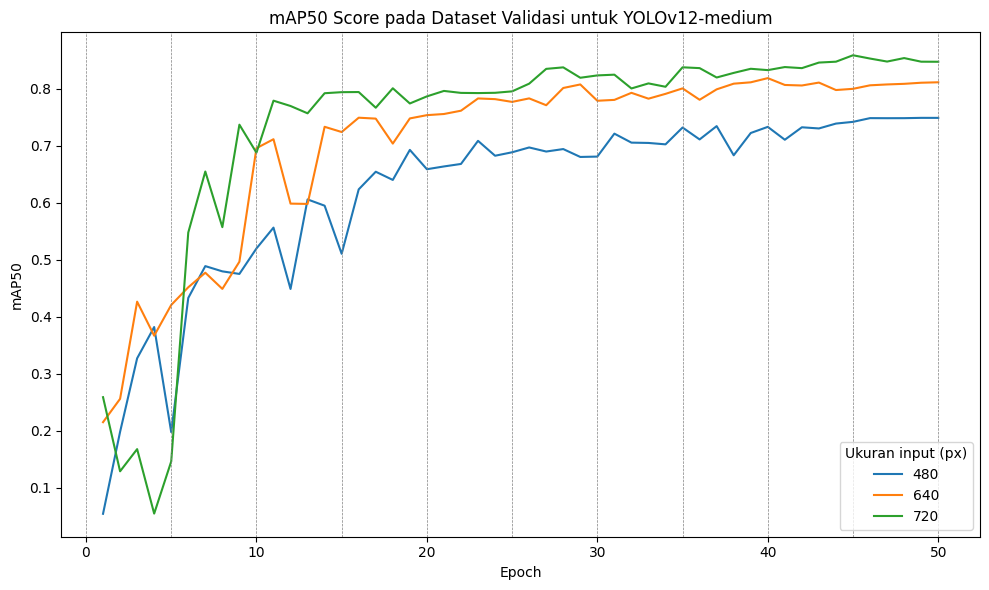

In [11]:
# Inisialisasi plot
fig = plt.figure(figsize=(10, 6))

# Plot data mAP50 untuk setiap ukuran input
for input_size, df in medium_train_results.items():
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label=input_size)

# Tambahkan garis vertikal setiap 5 epoch
min_epoch = int(min(df['epoch']))-1
max_epoch = int(max(df['epoch']))
for x in range(min_epoch, max_epoch + 1, 5):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

# Tambahkan informasi pada setiap plot
plt.xlabel('Epoch')
plt.ylabel('mAP50')
plt.title('mAP50 Score pada Dataset Validasi untuk YOLOv12-medium')
plt.legend(title='Ukuran input (px)', loc='lower right')

# Atur ticks pada sumbu X setiap 10 epoch
plt.xticks(range(min_epoch, max_epoch + 1, 10))

# Tampilkan plot
plt.tight_layout()
plt.show()


Perbedaan antara ukuran input tidak begitu signifikan pada YOLOv12-medium dibandingkan YOLOv12-small ataupun YOLOv12-nano. Ketiga model memiliki hasil yang tidak terlalu jauh satu sama lain menandakan model yang lebih besar sudah memiliki ekstraksi fitur yang lebih baik.

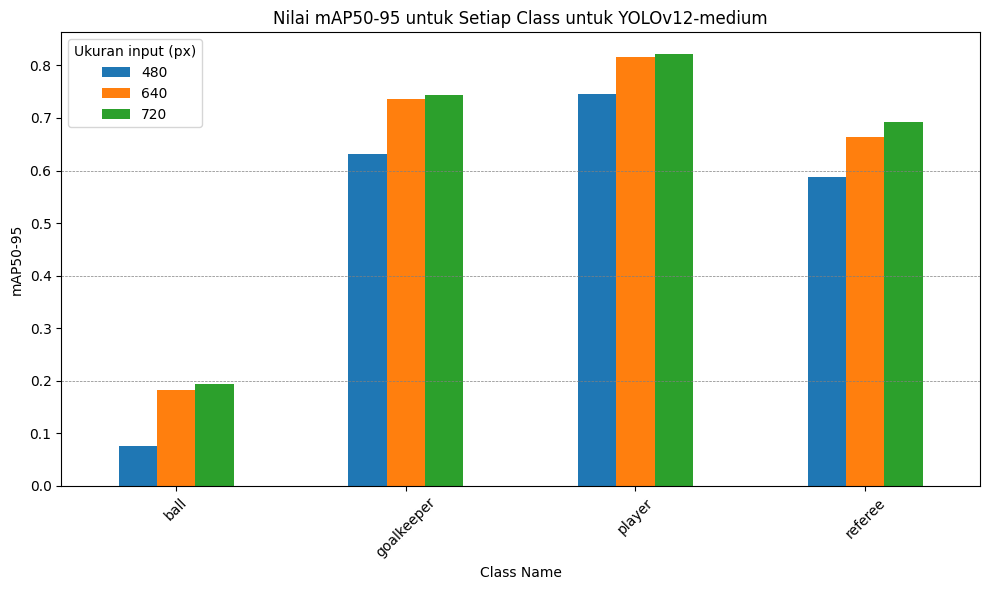

In [13]:
# Ambil data dan nilai mAP50
classes = medium_test_results['480']['Class Name']
model_names = list(medium_test_results.keys())
mAP50_95_values = {model: df['mAP50-95'].values for model, df in medium_test_results.items()}

# Buat dataframe dari nilai mAP50-95
data = pd.DataFrame(mAP50_95_values, index=classes)

# Inisialisasi plot
fig, ax = plt.subplots(figsize=(10, 6))

# Garis vertikal
for y in [0.2, 0.4, 0.6]:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

# Plot stacked barchart
data.plot(kind='bar', ax=ax)

# Tambahkan informasi pada graf
ax.set_xlabel('Class Name')
ax.set_ylabel('mAP50-95')
ax.set_title('Nilai mAP50-95 untuk Setiap Class untuk YOLOv12-medium')


# Print plot
plt.xticks(rotation=45)
plt.legend(title='Ukuran input (px)')
plt.tight_layout()
plt.show()

Perbedaan antara model YOLOv12-medium dengan ukuran input 640x640 dengan 720x720 sangat sedikit. Perbedaan antara ukuran input 480x480 dengan 640x640 juga tidak teralalu signifikan dibandingkan YOLOv12-small ataupun YOLOv12-nano. Pada titik ini, peningkatan ukuran input lebih dari 640x640 tidak diperlukan.

# Perbandingan hasil antar ukuran model

## Hasil Pelatihan

In [5]:
# Load seluruh hasil pelatihan
all_train_data = {
    '480' : {
        'n' : pd.read_csv('/kaggle/working/runs/detect/nano-480/results.csv'),
        's' : pd.read_csv('/kaggle/working/runs/detect/small-480/results.csv'),
        'm' : pd.read_csv('/kaggle/working/runs/detect/medium-480/results.csv'),
    },
    '640' : {
        'n' : pd.read_csv('/kaggle/working/runs/detect/nano-640/results.csv'),
        's' : pd.read_csv('/kaggle/working/runs/detect/small-640/results.csv'),
        'm' : pd.read_csv('/kaggle/working/runs/detect/medium-640/results.csv'),
    },
    '720' : {
        'n' : pd.read_csv('/kaggle/working/runs/detect/nano-720/results.csv'),
        's' : pd.read_csv('/kaggle/working/runs/detect/small-720/results.csv'),
        'm' : pd.read_csv('/kaggle/working/runs/detect/medium-720/results.csv'),
    },
}

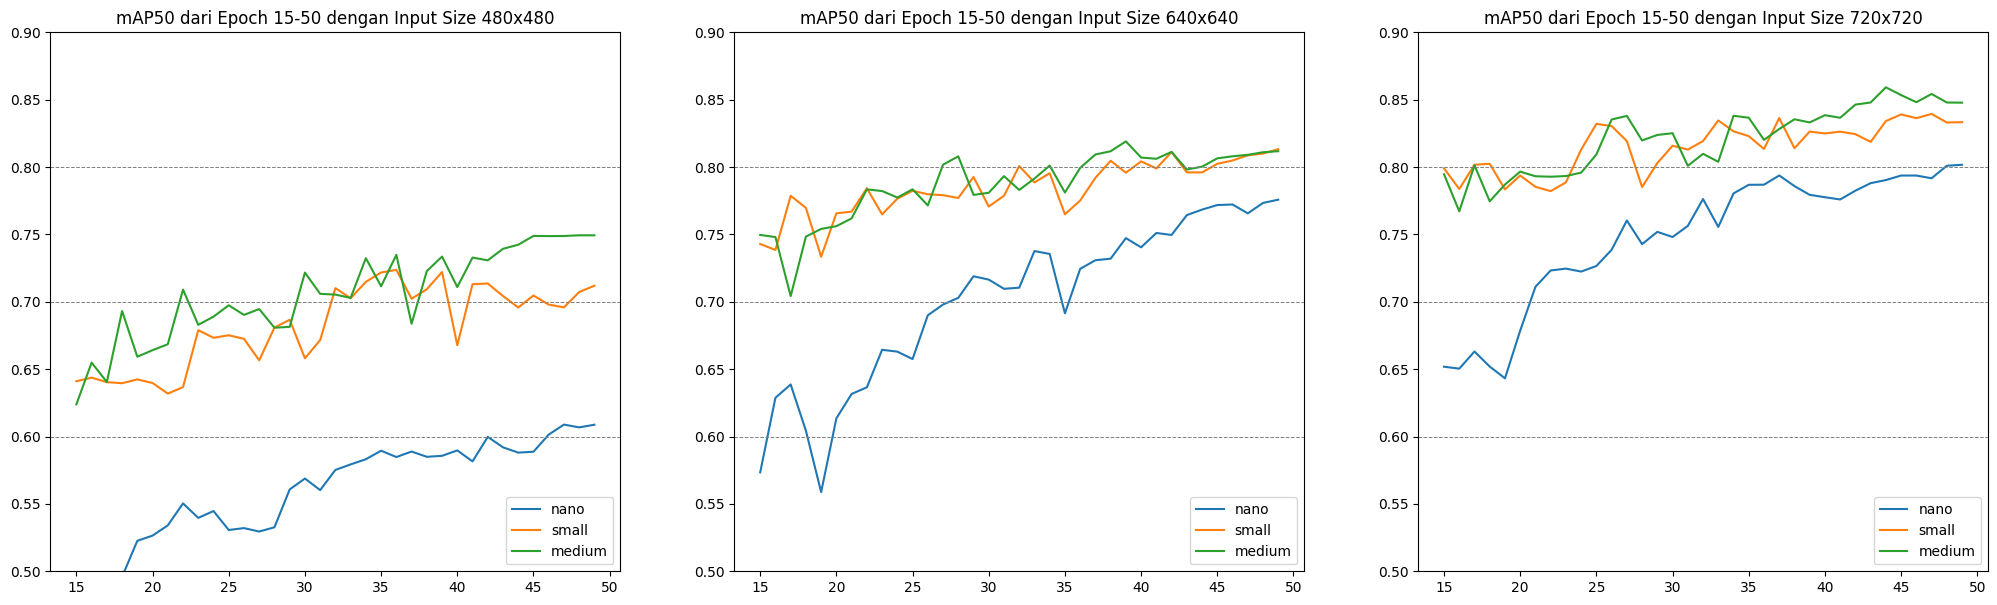

In [16]:
fig, axes = plt.subplots(1,3, figsize=(25,7))

for i, res in enumerate(['480', '640', '720']) :
    axes[i].plot(all_train_data[res]['n']['metrics/mAP50(B)'][15:], label='nano')
    axes[i].plot(all_train_data[res]['s']['metrics/mAP50(B)'][15:], label='small')
    axes[i].plot(all_train_data[res]['m']['metrics/mAP50(B)'][15:], label='medium')
    axes[i].set_ylim(0.5,0.9)
    for y in [0.6, 0.7, 0.8]:
        axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    axes[i].legend(loc='lower right')
    axes[i].set_title(f'mAP50 dari Epoch 15-50 dengan Input Size {res}x{res}')


plt.show()

Dari ketiga ukuran model, peningkatan signifikan terjadi antara YOLOv12-nano ke YOLOv12-small. Peningkatan tidak terlalu signifikan antara YOLOv12-small dan YOLOv12-medium. Berdasarkan hal tersebut **YOLOv12-small** memiliki balance terbaik antara kecepatan dan akurasi.

## Hasil Data Uji

In [11]:
# Load seluruh hasil testing
all_test_data = {
    '480' : {
        'n' : pd.read_csv('/kaggle/working/runs/detect/nano-480/test_results.txt', sep='\t'),
        's' : pd.read_csv('/kaggle/working/runs/detect/small-480/test_results.txt', sep='\t'),
        'm' : pd.read_csv('/kaggle/working/runs/detect/medium-480/test_results.txt', sep='\t'),
    },
    '640' : {
        'n' : pd.read_csv('/kaggle/working/runs/detect/nano-640/test_results.txt', sep='\t'),
        's' : pd.read_csv('/kaggle/working/runs/detect/small-640/test_results.txt', sep='\t'),
        'm' : pd.read_csv('/kaggle/working/runs/detect/medium-640/test_results.txt', sep='\t'),
    },
    '720' : {
        'n' : pd.read_csv('/kaggle/working/runs/detect/nano-720/test_results.txt', sep='\t'),
        's' : pd.read_csv('/kaggle/working/runs/detect/small-720/test_results.txt', sep='\t'),
        'm' : pd.read_csv('/kaggle/working/runs/detect/medium-720/test_results.txt', sep='\t'),
    },
}

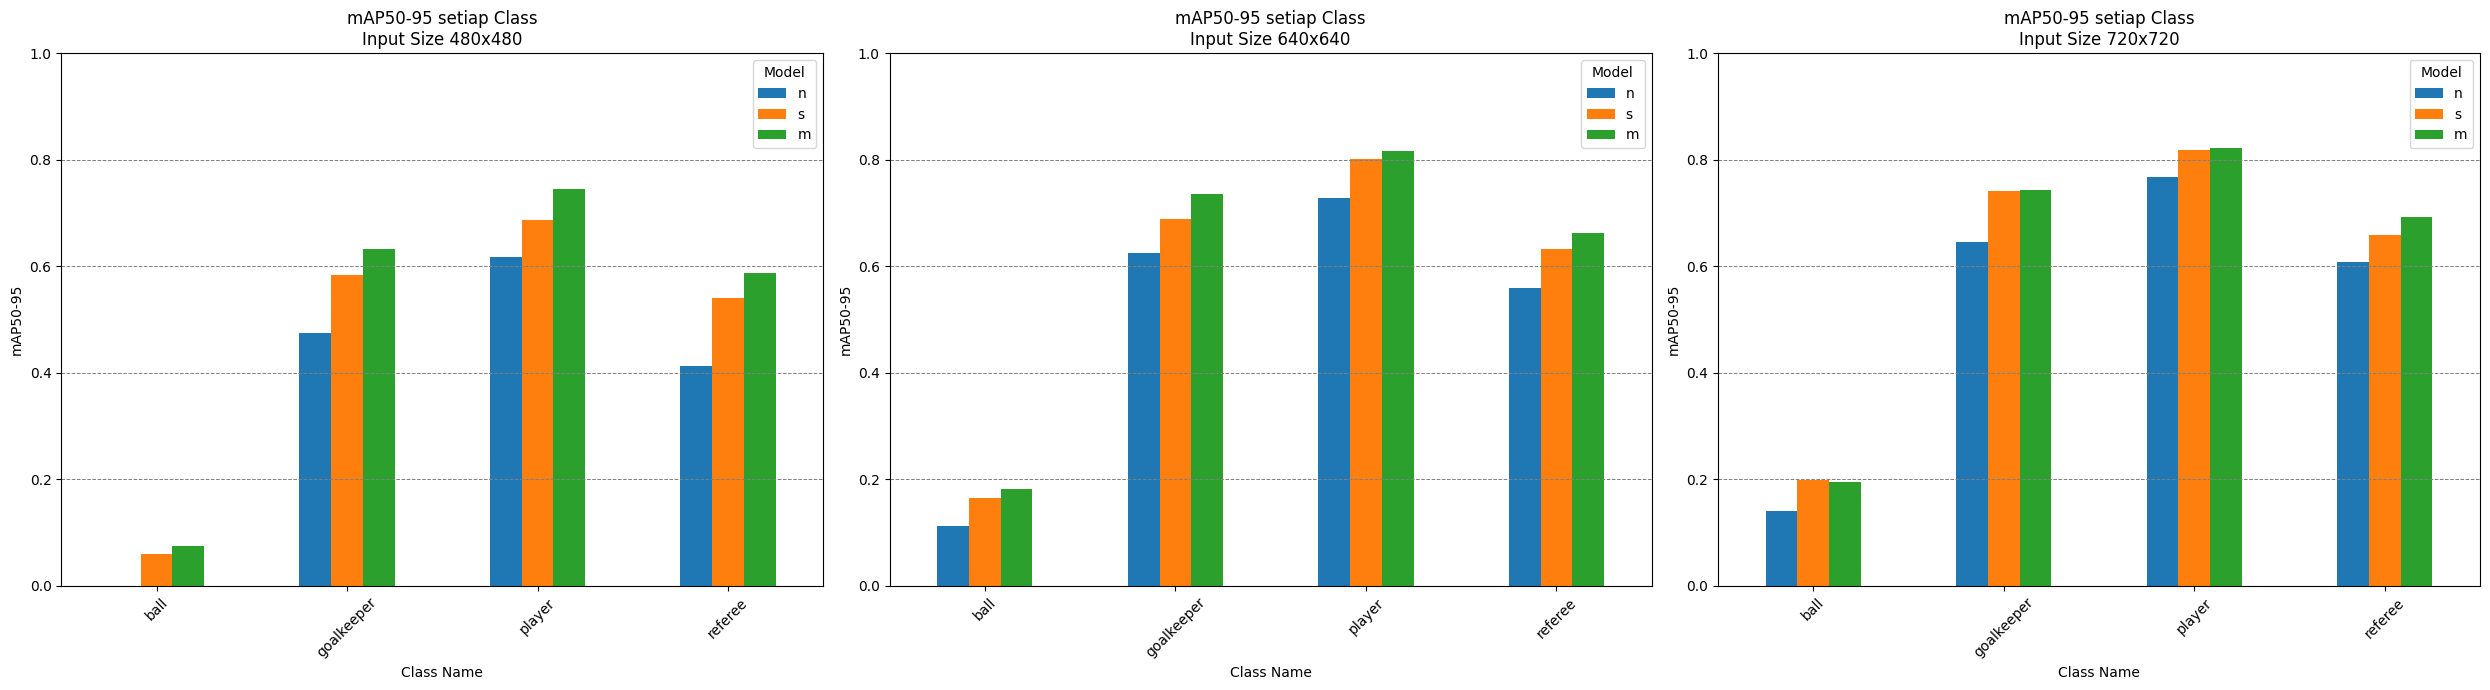

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

for i, res in enumerate(['480', '640', '720']):
    # Ambil nama class
    classes = all_test_data[res]['n']['Class Name']
    model_names = list(all_test_data[res].keys())
    
    # Ambil data mAP50-95 dari dictionary
    mAP50_95_values = {model: all_test_data[res][model]['mAP50-95'].values for model in model_names}
    
    # Ubah data ke format dataframe
    data = pd.DataFrame(mAP50_95_values, index=classes)
    
    # Plot stacked bar chart
    data.plot(kind='bar', ax=axes[i])

    # Tambah garis horizontal
    for y in [0.2, 0.4, 0.6, 0.8, 1.0]:
        axes[i].axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
    
    # Tambah informasi pada plot
    axes[i].set_xlabel('Class Name')
    axes[i].set_ylabel('mAP50-95')
    axes[i].set_title(f'mAP50-95 setiap Class\nInput Size {res}x{res}')
    axes[i].legend(title='Model', loc='upper right')
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Perbandingan antara input size juga terlihat bahwa model YOLOv12-small dengan input size 640x640 memiliki performa yang seimbang, dimana perbedaan performa ukuran model 480x480 dengan 640x640 memiliki peningkatan yang signifikan, sedangkan peningkatan antara model dengan ukuran input 640x640 dengan 720x720, peningkatan tidak terlalu signifikan.

Berdasarkan hal tersebut maka **YOLOv12-small dengan ukuran input 640x640 merupakan model terbaik yang memiliki *balance* antara performa dan kecepatan deteksi**